# Business Case 5

## Mind Over Data - Demand Forecasting 

#### Made by:
* Catarina Candeias (m20200656@novaims.unl.pt)
* Catarina Urbano (m20200607@novaims.unl.pt)
* Margarida Pereira (m20201038@novaims.unl.pt)
* Rita Ferreira (m20200661@novaims.unl.pt)

### Table of contents:

* [1. Business Understanding](#1)
* [2. Data Understanding](#2)
* [3. Data Preparation](#3)
* [4. Modeling and Evaluation](#4)
    * [4.1. Association Rules](#4.1)
    * [4.2. Customers Segmentation by product](#4.2)
* [5. Deployment](#5)

# 1. Business Understanding <a class="anchor" id="1"></a>

This section can be seen in detail in our report

# 2. Data Understanding <a class="anchor" id="2"></a>

#### Imports 

In [1]:
import os
from pathlib import Path
import pandas as pd
#import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from math import sqrt
import plotly.express as px
import calendar

from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth

from sklearn.base import clone
from sklearn.metrics import pairwise_distances

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               # from sompy.sompy import SOMFactory                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                # from sompy.visualization.mapview import View2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              # from sompy.visualization.bmuhits import BmuHitsVi                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
sns.set_style(style='white')
import warnings
warnings.filterwarnings('ignore')


import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from random import sample,seed


from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults


#to show all columns and rows when displaying a dataframe
pd.set_option('display.max_columns', None)

# Defining PROJECT_ROOT
PROJECT_ROOT = Path(os.path.abspath('')).resolve().parents[0]

### 2.1. Collect Initial Data <a class="anchor" id="2.1"></a>

In [2]:
# Load data
df = pd.read_csv('df_preprocessed.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Sell-out units,Sell-out values
0,1,33,313,657,1984,2,2018-06-21,1.0,655.0
1,1,33,313,657,1984,2,2018-08-08,1.0,655.0
2,1,33,313,657,1984,2,2018-08-23,1.0,655.0
3,1,33,313,657,1984,2,2018-10-07,1.0,655.0
4,1,33,313,657,1984,2,2018-12-15,1.0,655.0


### 2.2. Describe, explore and assess data quality <a class="anchor" id="2.2"></a>
Note that this is an interactive process, so in order to perform better exploration and assessment of our data some data cleaning was needed in this step

In [3]:
# Get the row and column count,columns and their datatypes and presence of null values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91161169 entries, 0 to 91161168
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ProductFamily_ID    int64  
 1   ProductCategory_ID  int64  
 2   ProductBrand_ID     int64  
 3   ProductName_ID      int64  
 4   ProductPackSKU_ID   int64  
 5   Point-of-Sale_ID    int64  
 6   Date                object 
 7   Sell-out units      float64
 8   Sell-out values     float64
dtypes: float64(2), int64(6), object(1)
memory usage: 6.1+ GB


##### Note:
- the variable Date should be datetime and not a float

In [4]:
# shape of df:
df.shape

(91161169, 9)

In [5]:
# Check for duplicates:
# df.drop_duplicates().shape

In [3]:
# To avoid errors:
df.replace("", np.nan, inplace=True)

In [7]:
# Checking if there are white spaces where they aren´t supposed to be
lst = []
for column in df.columns:
    if (df[column].isin([' ']).sum()>0):
        lst.append(column)
print(lst)

[]


In [8]:
# Check for missing values:
display(df.isna().sum())

ProductFamily_ID      0
ProductCategory_ID    0
ProductBrand_ID       0
ProductName_ID        0
ProductPackSKU_ID     0
Point-of-Sale_ID      0
Date                  0
Sell-out units        0
Sell-out values       0
dtype: int64

In [9]:
# some statistics:
df[['Sell-out units','Sell-out values']].describe(include='all')



,Sell-out units,Sell-out values
count,9.116117e+07,9.116117e+07
mean,2.180195e+00,3.518611e+03
std,2.291201e+00,6.657410e+03
min,0.000000e+00,-1.000000e+01
25%,1.000000e+00,8.600000e+02
50%,1.000000e+00,1.654000e+03
75%,2.000000e+00,3.420000e+03
max,2.870000e+02,6.625750e+05


#### Outliers detection 

In [3]:
metric_features =["Sell-out units","Sell-out values"]

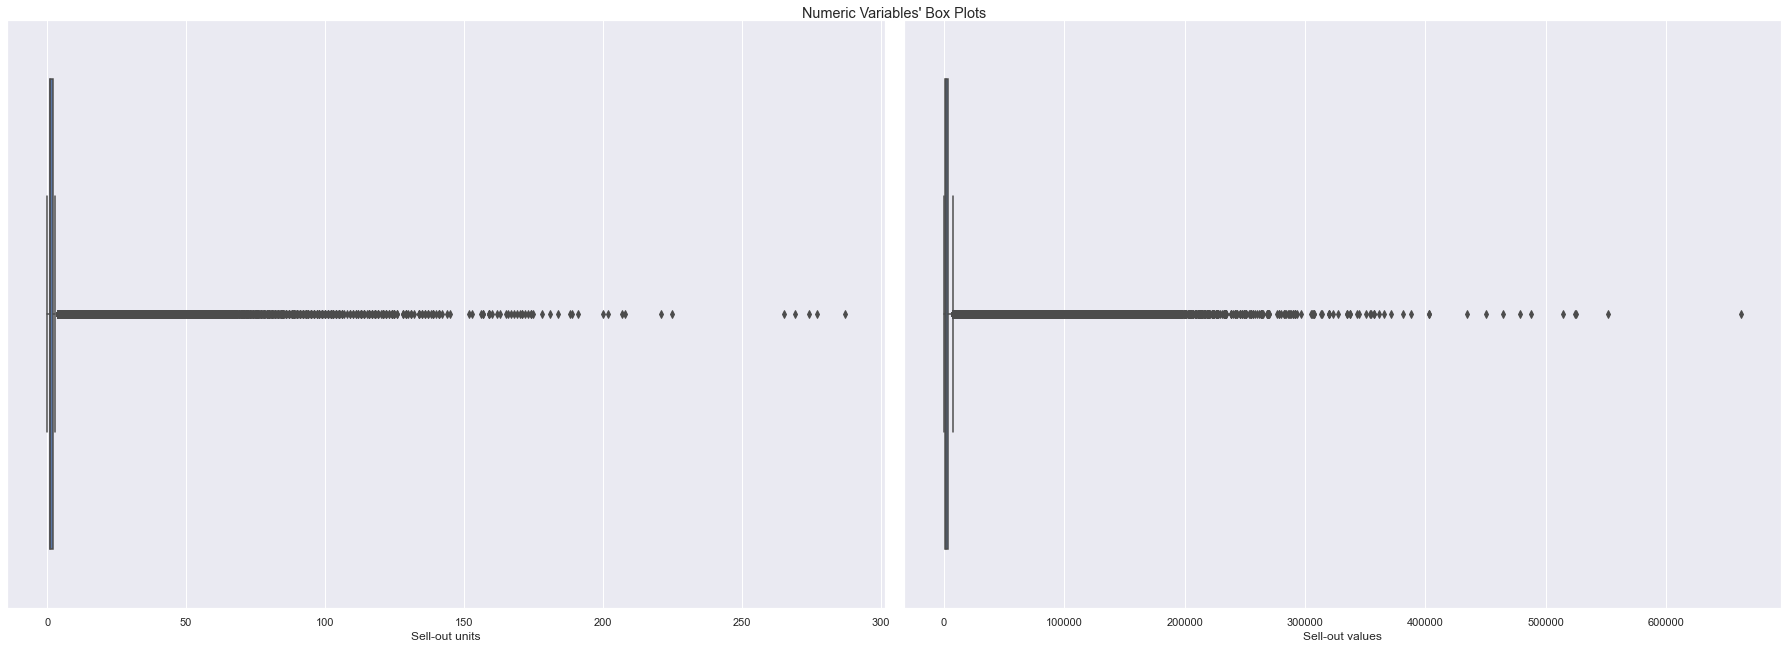

In [11]:
# check boxplots and univariate outliers

# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(1, 2, figsize=(25, 9), squeeze=True)

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), metric_features): 
    sns.boxplot(x=df[feat], ax=ax)
#     ax.set_title(feat, y=-0.21)

# Adjusting my subplots:
fig.tight_layout()

# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"
plt.suptitle(title,y=1)

plt.show()

##### Some required data preparation to enable good data exploration at this step:

In [4]:
#Convert to proper format
df['Date'] = pd.to_datetime(df['Date'])

# 'Sell-out units' should be integer:
df['Sell-out units'] = df['Sell-out units'].astype(int)

Removing Discontinued products -> products not sold in the 6 months prior to the most recent date in our data :

In [5]:
days_without_selling_product_X = df['Date'].max() - df.groupby('ProductName_ID')['Date'].max()
days_without_selling_product_X = days_without_selling_product_X.apply(lambda x: int(str(x).split()[0]))

descontinued_products = days_without_selling_product_X[days_without_selling_product_X>6*30].index

# removing from our df
df = df[~df['ProductName_ID'].isin(descontinued_products)]

### Visualizations

Dataframe with Quarterly information:

In [5]:
df_quarter = df.groupby(by=[df['Date'].dt.to_period('Q'),'ProductFamily_ID','ProductCategory_ID','ProductBrand_ID','ProductName_ID','ProductPackSKU_ID','Point-of-Sale_ID'])[['Sell-out units','Sell-out values']].sum()
df_quarter

Sell-out units  \
Date   ProductFamily_ID ProductCategory_ID ProductBrand_ID ProductName_ID ProductPackSKU_ID Point-of-Sale_ID                   
2016Q1 1                33                 313             657            1984              4                              1   
                                                                                            6                              1   
                                                                                            8                             10   
                                                                                            9                              1   
                                                                                            13                            35   
                                                                                            14                             4   
                                                                                            15                             5   
                                                                                            17                            19   
                                                                                            19                             1   
                                                                                            20                             4   
                                                                                            25                             1   
                                                                                            26                             3   
                                                                                            29                            11   
                                                                                            31                            10   
                                                                                            32                             8   
                                                                                            33                             4   
                                                                                            34                             8   
                                                                                            35                            35   
                                                                                            36                             7   
                                                                                            37                             3   
                                                                                            38                             8   
                                                                                            39                             9   
                                                                                            44                             8   
                                                                                            45                             3   
                                                                                            46                            11   
                                                                                            47                            10   
                                                                                            48                             4   
                                                                                            56                            10   
                                                                                            57                             1   
                                                                                            64                             6   
...           

##### Most sold products

In [6]:
products_grouped = df.groupby(['ProductName_ID']).agg({'Sell-out units': 'sum'}).reset_index()
products_grouped['percentage']  = products_grouped['Sell-out units']/(products_grouped['Sell-out units'].sum())*100
products_grouped.rename(columns = {'ProductName_ID':'Product ID', 'Sell-out units':'Sell-out units sum'}, inplace = True)
products_grouped = products_grouped.sort_values(['Sell-out units sum'], ascending = 0)
products_grouped

,Product ID,Sell-out units sum,percentage
1265,1277,3170644,1.595299e+00
2579,2609,3070767,1.545047e+00
478,481,2983615,1.501196e+00
983,993,2837871,1.427866e+00
1136,1147,2801152,1.409391e+00
1223,1234,2528299,1.272106e+00
2771,2802,2521723,1.268797e+00
840,847,2447082,1.231242e+00
225,226,2437992,1.226668e+00
1408,1422,2414561,1.214879e+00


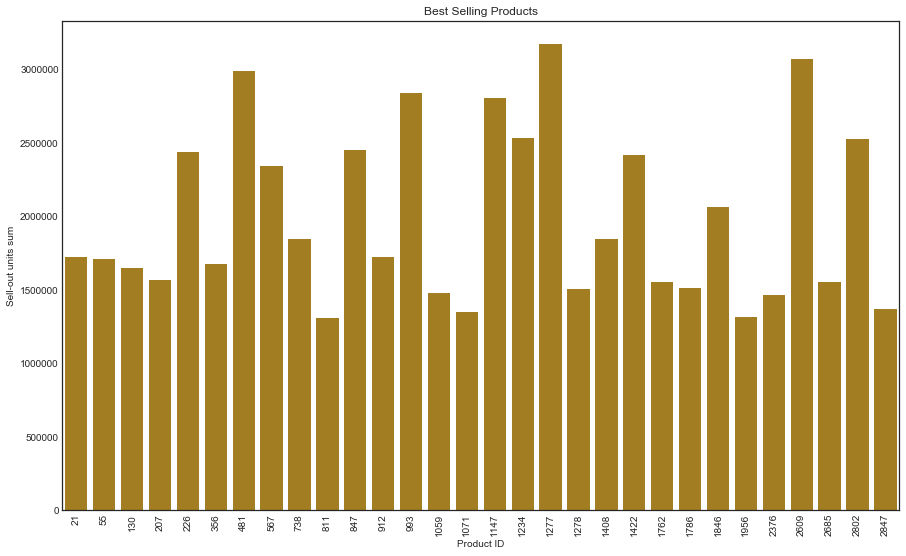

In [9]:
plt.figure(figsize=(15,9))
sns.barplot(data=products_grouped.head(30),x="Product ID",y="Sell-out units sum",orient="v",color='darkgoldenrod')
plt.xticks(rotation=90)
plt.title("Best Selling Products")
plt.xlabel('Product ID')
plt.ylabel("Sell-out units sum")

##### Most sold Brands

In [8]:
products_brand_grouped = df.groupby(['ProductBrand_ID']).agg({'Sell-out units': 'sum'}).reset_index()
products_brand_grouped['percentage']  = products_brand_grouped['Sell-out units']/(products_brand_grouped['Sell-out units'].sum())*100
products_brand_grouped.rename(columns = {'ProductBrand_ID':'Product Brand ID', 'Sell-out units':'Sell-out units sum'}, inplace = True)
products_brand_grouped = products_brand_grouped.sort_values(['Sell-out units sum'], ascending = 0)
products_brand_grouped

,Product Brand ID,Sell-out units sum,percentage
483,487,3555723,1.789051e+00
1397,1410,3426690,1.724128e+00
638,643,3170644,1.595299e+00
224,226,2983615,1.501196e+00
931,940,2850426,1.434183e+00
569,574,2801152,1.409391e+00
540,544,2766761,1.392087e+00
613,618,2528299,1.272106e+00
1496,1509,2521723,1.268797e+00
424,428,2447082,1.231242e+00


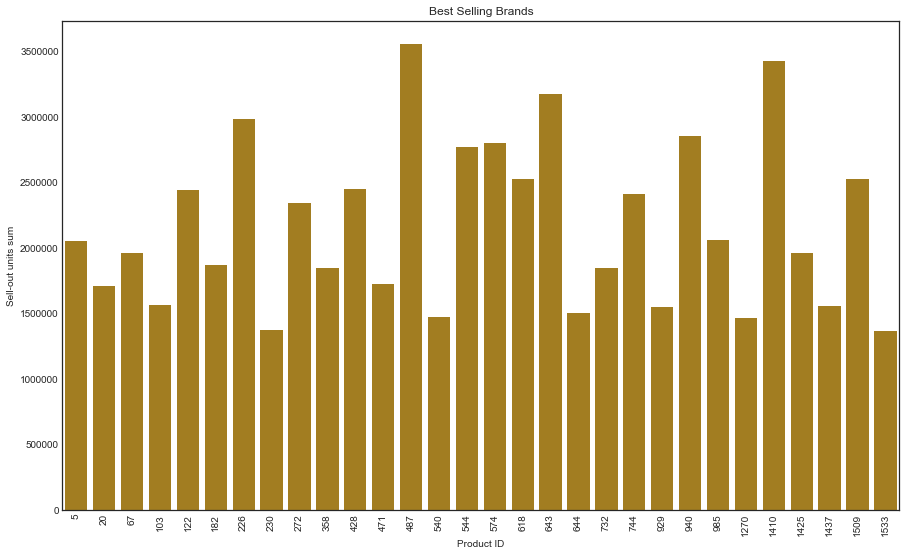

In [10]:
plt.figure(figsize=(15,9))
sns.barplot(data=products_brand_grouped.head(30),x="Product Brand ID",y="Sell-out units sum",orient="v",color='darkgoldenrod')
plt.xticks(rotation=90)
plt.title("Best Selling Brands")
plt.xlabel('Product ID')
plt.ylabel("Sell-out units sum")

#### Point of sale as a whole:

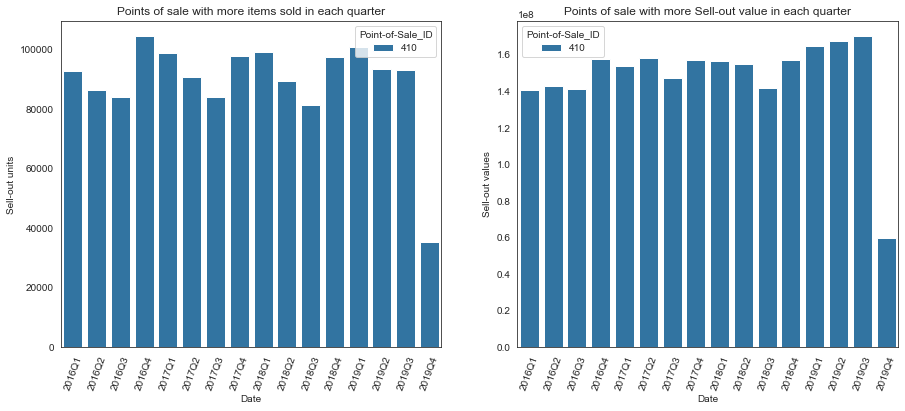

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
# Point of sale with more items sold in each quarter
aux2 = df_quarter.reset_index().groupby(by=['Date','Point-of-Sale_ID'])['Sell-out units'].sum().to_frame().reset_index()
aux2 = aux2.groupby(by=['Date']).max()
aux2.reset_index(inplace=True)
sns.barplot(x="Date", y="Sell-out units",hue='Point-of-Sale_ID', data=aux2,ax=ax1)
ax1.tick_params(axis='x',labelrotation=70)
ax1.set_title('Points of sale with more items sold in each quarter')
# plt.show()

# Point of sale with more Sell-out value in each quarter
aux2 = df_quarter.reset_index().groupby(by=['Date','Point-of-Sale_ID'])['Sell-out values'].sum().to_frame().reset_index()
aux2 = aux2.groupby(by=['Date']).max()
aux2.reset_index(inplace=True)
ax2 = sns.barplot(x="Date", y="Sell-out values",hue='Point-of-Sale_ID', data=aux2,ax=ax2)
ax2.tick_params(axis='x',labelrotation=70)
ax2.set_title('Points of sale with more Sell-out value in each quarter')
plt.show()

####  Quarterly analysis of Top products sold -  for a certain point of sale 

In [108]:
def top_products_quarter(df,Point_of_Sale_ID,quarter=None):
    if quarter!=None:
        aux=df[(df['Point-of-Sale_ID']==Point_of_Sale_ID) & (df['Date']==quarter)].groupby(by=['ProductName_ID'])[['Sell-out values']].sum().nlargest(5,'Sell-out values').reset_index()
        title = 'Top products sold in '+str(quarter)+' for the point of sale with ID '+str(Point_of_Sale_ID)

        x_pos = [0,1,2,3,4]
        plt.bar(x_pos, aux['Sell-out values'],color='darkgoldenrod')
        plt.xticks(x_pos, aux['ProductName_ID'])
        plt.xlabel('ProductName_ID')
        plt.ylabel('Sell-out values')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        aux=df.reset_index()[df.reset_index()['Point-of-Sale_ID']==Point_of_Sale_ID]
        aux_df=pd.DataFrame()
        for i in df_quarter.reset_index().Date.unique():
            aux1 = aux[aux['Date']==i].groupby(by=['Date','ProductName_ID'])[['Sell-out values']].sum().nlargest(5,'Sell-out values')
            aux_df=pd.concat([aux_df, aux1])
            title = 'Top products sold in each quarter for the point of sale with ID '+str(Point_of_Sale_ID)
        aux_df.reset_index(inplace=True)
        aux_df.Date = aux_df.Date.astype(str) 
        aux_df.ProductName_ID = aux_df.ProductName_ID.astype(str) 
        fig = px.bar(aux_df, x="Date", y="Sell-out values", color='ProductName_ID', title=title,color_discrete_sequence=px.colors.qualitative.Antique)#Dark2
        fig.show(renderer="png")

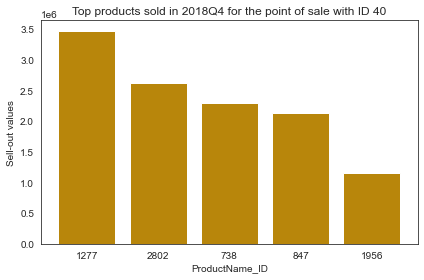

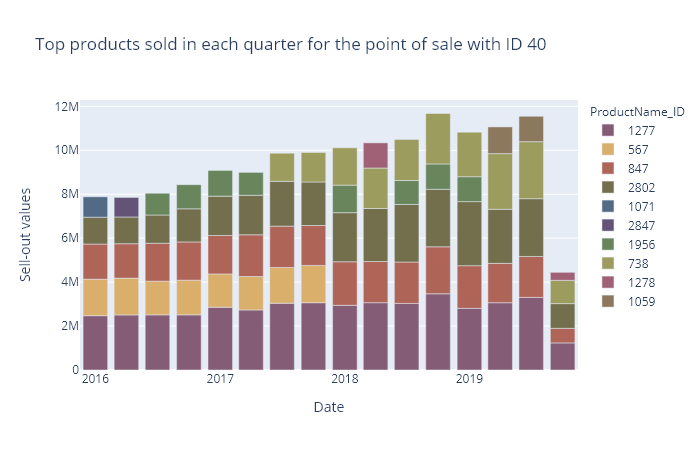

In [157]:
top_products_quarter(df_quarter,40,'2018Q4')
top_products_quarter(df_quarter,40)

#### Quarterly analysis of Market Share 

% of revenue (proportion) for each category and family for each point of sales

In [13]:
total_value = df_quarter['Sell-out values'].sum()

In [14]:
df_quarter['% of revenue'] = df_quarter['Sell-out values'] / total_value

##### Product Family

In [155]:
def product_family_quarter(df,Point_of_Sale_ID,quarter=None):
    if quarter!=None:
        aux=df[(df['Point-of-Sale_ID']==Point_of_Sale_ID) & (df['Date']==quarter)].groupby(by=['ProductFamily_ID'])[['% of revenue']].sum().nlargest(5,'% of revenue').reset_index()
        title = 'Top Market Share Product Families in '+str(quarter)+' for the POS '+str(Point_of_Sale_ID) 
        x_pos = [0,1,2,3,4]
        plt.bar(x_pos, aux['% of revenue'],color='darkgoldenrod')
        plt.xticks(x_pos, aux['ProductFamily_ID'])
        plt.xlabel('ProductFamily_ID')
        plt.ylabel('% of revenue')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        aux=df.reset_index()[df.reset_index()['Point-of-Sale_ID']==Point_of_Sale_ID]
        aux_df=pd.DataFrame()
        for i in df_quarter.reset_index().Date.unique():
            aux1 = aux[aux['Date']==i].groupby(by=['Date','ProductFamily_ID'])[['% of revenue']].sum().nlargest(5,'% of revenue')
            aux_df=pd.concat([aux_df, aux1])
            title = 'Top Market Share Product Families in each quarter for the point of sale with ID '+str(Point_of_Sale_ID)
        aux_df.reset_index(inplace=True)
        aux_df.Date = aux_df.Date.astype(str) 
        aux_df.ProductFamily_ID = aux_df.ProductFamily_ID.astype(str)
        fig = px.bar(aux_df, x="Date", y='% of revenue', color='ProductFamily_ID', title=title,color_discrete_sequence=px.colors.qualitative.Antique)
        fig.show(renderer="png")


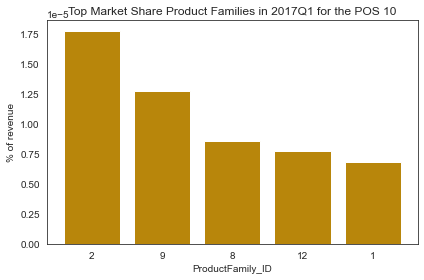

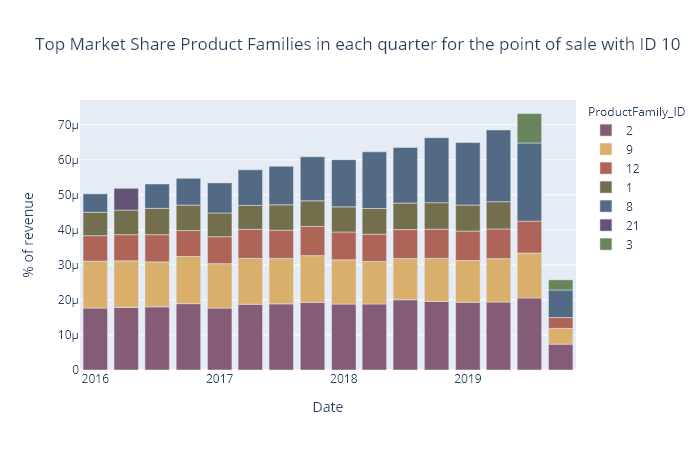

In [158]:
product_family_quarter(df_quarter,10,'2017Q1')
product_family_quarter(df_quarter,10)

##### Product Category 

In [133]:
def product_category_quarter(df,Point_of_Sale_ID,quarter=None):
    if quarter!=None:
        aux=df[(df['Point-of-Sale_ID']==Point_of_Sale_ID) & (df['Date']==quarter)].groupby(by=['ProductCategory_ID'])[['% of revenue']].sum().nlargest(5,'% of revenue').reset_index()
        title = 'Top Market Share Product Categories in '+str(quarter)+' for the POS '+str(Point_of_Sale_ID) 
        x_pos = [0,1,2,3,4]
        plt.bar(x_pos, aux['% of revenue'],color='darkgoldenrod')
        plt.xticks(x_pos, aux['ProductCategory_ID'])
        plt.xlabel('ProductCategory_ID')
        plt.ylabel('% of revenue')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        aux=df.reset_index()[df.reset_index()['Point-of-Sale_ID']==Point_of_Sale_ID]
        aux_df=pd.DataFrame()
        for i in df_quarter.reset_index().Date.unique():
            aux1 = aux[aux['Date']==i].groupby(by=['Date','ProductCategory_ID'])[['% of revenue']].sum().nlargest(5,'% of revenue')
            aux_df=pd.concat([aux_df, aux1])
            title = 'Top Market Share Product Categories in each quarter for the point of sale with ID '+str(Point_of_Sale_ID)
        aux_df.reset_index(inplace=True)
        aux_df.Date = aux_df.Date.astype(str) 
        aux_df.ProductCategory_ID = aux_df.ProductCategory_ID.astype(str)
        fig = px.bar(aux_df, x="Date", y='% of revenue', color='ProductCategory_ID', title=title,color_discrete_sequence=px.colors.qualitative.Antique)
        fig.show(renderer="png")

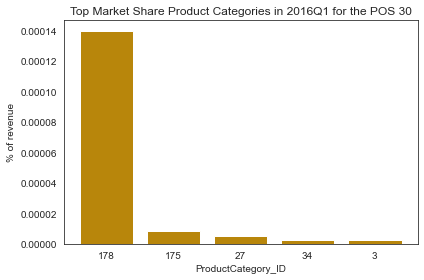

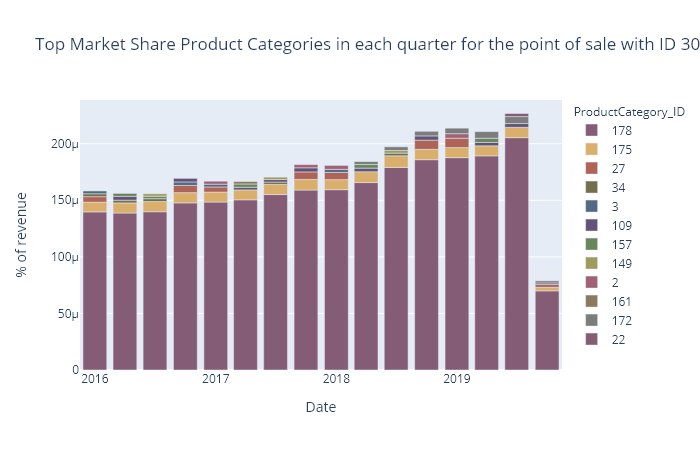

In [159]:
product_category_quarter(df_quarter,30,'2016Q1')
product_category_quarter(df_quarter,30)

##### Quarterly analysis of Preferences 


In [ ]:
df['Point-of-Sale_ID'].unique()

In [151]:
def pref_product_quarter(df,Point_of_Sale_ID,quarter=None):
    aux=df.reset_index()[df.reset_index()['Point-of-Sale_ID']==Point_of_Sale_ID]
    if quarter!=None:
        aux_df = aux[aux['Date']==quarter].groupby(by=['Date','ProductName_ID'])[['Sell-out units']].sum().nlargest(5,'Sell-out units')
        title = 'ProductNameID Preferences in '+str(quarter)+' for the point of sale with ID '+str(Point_of_Sale_ID) 
    else:
        aux_df=pd.DataFrame()
        for i in df_quarter.reset_index().Date.unique():
            aux1 = aux[aux['Date']==i].groupby(by=['Date','ProductName_ID'])[['Sell-out units']].sum().nlargest(5,'Sell-out units')
            aux_df=pd.concat([aux_df, aux1])
            title = 'ProductNameID Preferences in each quarter for the point of sale with ID '+str(Point_of_Sale_ID)
    aux_df.reset_index(inplace=True)
    aux_df.Date = aux_df.Date.astype(str) 
    aux_df.ProductName_ID = aux_df.ProductName_ID.astype(str)
    fig = px.sunburst(aux_df, path=['Date','ProductName_ID'], color="ProductName_ID", values ='Sell-out units', title=title,color_discrete_sequence=px.colors.qualitative.Dark2)
    
    fig.show(renderer="png")

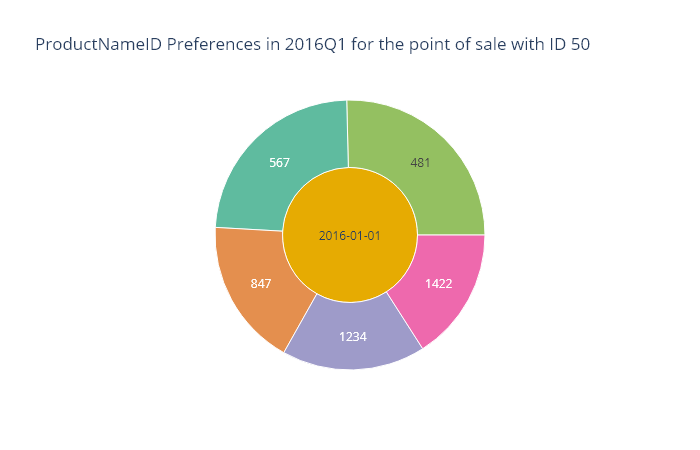

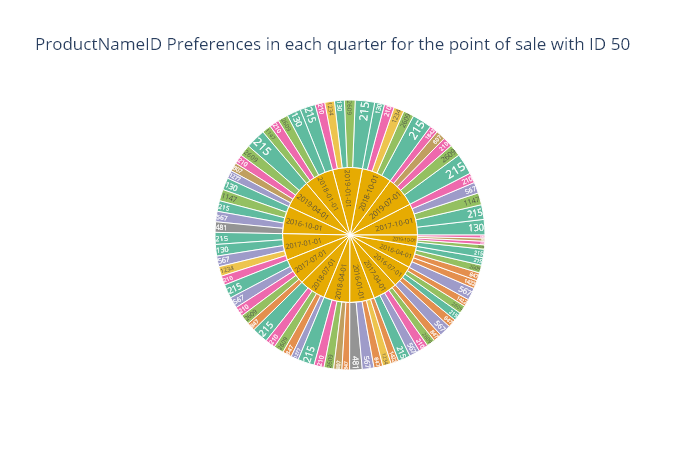

In [160]:
pref_product_quarter(df_quarter,50,'2016Q1')
pref_product_quarter(df_quarter,50)

#### At What Day Of The Week People Order?

In [17]:
def get_dow(x):
    return calendar.day_name[x.weekday()]
df['dow'] = df['Date'].map(get_dow)

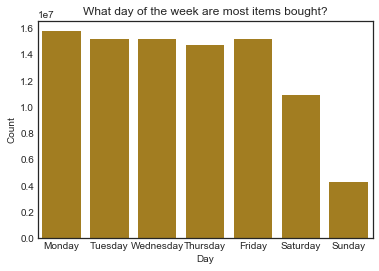

In [31]:
plt.figure(figsize = (10,6))
ordem=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
ax2 = sns.barplot(x = "dow", y = "index", data = df.reset_index(), color = "darkgoldenrod", order=ordem)
ax2.set(xlabel='Day', ylabel='Count')
ax2.set_title('What day of the week are most items bought?')
plt.savefig('DOW.png', transparent=True)
plt.show()


##### Product co-ocorrences -> Association Rules

Removing new products -> products only sold in the 2 weeks before the most recent date in our data :

In [6]:
x = df.groupby('ProductName_ID')['Date'].min()
# Products in which the less recent date was less than 2 weeks before the most recent data in our data:
new_products = x[x>'2019-10-15 00:00:00'].index
# removing from our df_aux
df = df[~df['ProductName_ID'].isin(new_products)]

In [ ]:
len(df['ProductName_ID'].unique())

In [ ]:
df['Quarter'] = pd.PeriodIndex(df['Date'], freq='Q')

In [ ]:
# convert quarter to string datatype to search and split the dataframe by quarter
df['Quarter'] = df['Quarter'].astype(str)

In [ ]:
# splitting the dataframe into three new ones based on the three last quarters of 2019
df_quarter2 = df[df['Quarter'].str.contains('2019Q2')]
df_quarter3 = df[df['Quarter'].str.contains('2019Q3')]
df_quarter4 = df[df['Quarter'].str.contains('2019Q4')]

###### AR with product family 

2nd Quarter of 2019 :

In [4]:
for i in (df_quarter2['ProductFamily_ID'].unique()):
    if len(df_quarter2[df_quarter2['ProductFamily_ID']==i]) <=30000 :
        df_quarter2.drop(df_quarter2.loc[df_quarter2['ProductFamily_ID'] == i].index, inplace=True)

In [5]:
productfamily_q2 = df_quarter2['ProductFamily_ID']
df_aux1 = df_quarter2[df_quarter2['ProductFamily_ID'].isin(productfamily_q2)] 

In [6]:
basket1 = df_aux1.groupby(['Point-of-Sale_ID','ProductFamily_ID'])['Date'].count().unstack().reset_index().fillna(0).set_index('Point-of-Sale_ID')
basket1

ProductFamily_ID,1,2,3,5,6,7,8,9,10,12,14,15,16,18,21
Point-of-Sale_ID,,,,,,,,,,,,,,,
1,2135,736,301,82,190,59,332,2924,148,2619,353,661,145,431,1457
2,2115,722,236,74,156,66,322,2741,84,2580,362,696,187,326,970
3,3135,957,357,108,326,122,423,4249,117,3460,411,826,194,550,1559
4,4251,1122,371,105,394,102,449,5969,278,5773,483,1166,210,617,4720
5,2334,928,321,105,243,80,349,4067,129,3493,374,782,179,479,1509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,2013,866,269,78,144,53,312,2747,120,2803,409,679,247,456,2359
407,3116,1076,368,86,190,109,319,4092,172,4247,492,1125,417,645,3590
408,2025,746,301,82,93,58,234,2313,108,2889,435,855,292,592,1757


3rd Quarter of 2019 :

In [7]:
for i in (df_quarter3['ProductFamily_ID'].unique()):
    if len(df_quarter3[df_quarter3['ProductFamily_ID']==i]) <=30000 :
        df_quarter3.drop(df_quarter3.loc[df_quarter3['ProductFamily_ID'] == i].index, inplace=True)

In [8]:
productfamily_q3 = df_quarter3['ProductFamily_ID']
df_aux2 = df_quarter3[df_quarter3['ProductFamily_ID'].isin(productfamily_q3)] 

In [9]:
basket2 = df_aux2.groupby(['Point-of-Sale_ID','ProductFamily_ID'])['Date'].count().unstack().reset_index().fillna(0).set_index('Point-of-Sale_ID')
basket2

ProductFamily_ID,1,2,3,5,6,7,8,9,10,12,14,15,16,18,21
Point-of-Sale_ID,,,,,,,,,,,,,,,
1,2341,754,315,96,171,70,362,3022,168,2683,337,551,104,469,1794
2,2275,725,266,72,144,74,333,2751,95,2634,300,525,130,359,1015
3,3295,1004,392,103,278,127,436,4475,112,3609,323,602,143,533,1476
4,4458,1195,393,109,404,101,479,5991,284,5981,446,907,182,650,4691
5,2482,944,340,104,227,79,360,4141,154,3512,323,558,143,451,1539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,2048,938,320,82,146,61,323,2819,117,2955,356,543,145,458,2450
407,3241,1128,407,90,182,116,366,4256,172,4455,456,814,276,667,3608
408,2294,774,340,80,80,60,268,2355,109,2976,369,629,213,587,1632


4th Quarter of 2019:

In [10]:
for i in (df_quarter4['ProductFamily_ID'].unique()):
    if len(df_quarter4[df_quarter4['ProductFamily_ID']==i]) <=30000 :
        df_quarter4.drop(df_quarter4.loc[df_quarter4['ProductFamily_ID'] == i].index, inplace=True)

In [11]:
productfamily_q4 = df_quarter4['ProductFamily_ID']
df_aux4= df_quarter4[df_quarter4['ProductFamily_ID'].isin(productfamily_q4)]

In [12]:
basket3 = df_aux4.groupby(['Point-of-Sale_ID','ProductFamily_ID'])['Date'].count().unstack().reset_index().fillna(0).set_index('Point-of-Sale_ID')
basket3

ProductFamily_ID,1,2,3,8,9,12,14,15,16,18,21
Point-of-Sale_ID,,,,,,,,,,,
1,744,240,119,120,1002,905,181,317,63,163,363
2,769,258,96,126,1001,945,169,289,80,122,287
3,1143,367,137,154,1587,1296,194,372,98,211,448
4,1544,389,151,164,2083,2094,196,445,95,220,1258
5,824,323,126,122,1381,1246,171,287,98,163,421
...,...,...,...,...,...,...,...,...,...,...,...
406,674,302,111,115,914,960,172,224,66,159,740
407,1090,385,157,116,1421,1518,198,343,115,224,952
408,761,261,129,94,829,1049,179,306,95,204,512


###### AR with product category  

In [13]:
df_quarter2['ProductCategory_ID'].value_counts().head(15) # use the threshold value as 42784 since we only want to retrive the 15
# product categories with more occurrences / counts

178    4337500
175     206402
22      147088
27      122119
3       117097
157      85511
34       82285
2        82132
11       61075
109      56627
149      54435
161      52904
39       47160
1        43798
127      42784
Name: ProductCategory_ID, dtype: int64

2nd Quarter of 2019 :

In [14]:
for i in (df_quarter2['ProductCategory_ID'].unique()) :
    if len(df_quarter2[df_quarter2['ProductCategory_ID']==i])< 42784 :
        df_quarter2.drop(df_quarter2.loc[df_quarter2['ProductCategory_ID'] == i].index, inplace=True)

In [15]:
productcategory_q2 = df_quarter2['ProductCategory_ID']
df_aux4 = df_quarter2[df_quarter2['ProductCategory_ID'].isin(productcategory_q2)] 

In [16]:
basket4 = df_aux4.groupby(['Point-of-Sale_ID','ProductCategory_ID'])['Date'].count().unstack().reset_index().fillna(0).set_index('Point-of-Sale_ID')
basket4

ProductCategory_ID,1,2,3,11,22,27,34,39,109,127,149,157,161,175,178
Point-of-Sale_ID,,,,,,,,,,,,,,,
1,80,165,330,120,320,246,189,85,77,30,54,91,87,431,9353
2,108,148,341,141,251,281,155,65,87,40,24,94,67,326,8980
3,100,244,359,167,289,313,165,86,137,48,45,176,55,550,13103
4,234,304,463,217,636,393,391,139,363,178,240,540,364,611,18441
5,177,159,373,181,298,301,202,68,90,56,66,132,84,477,11888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,80,188,321,259,310,323,322,202,42,88,95,167,77,448,9228
407,173,214,537,405,395,372,350,196,78,175,253,269,230,623,13550
408,146,144,380,308,213,338,212,126,26,83,105,144,65,572,8710


3rd Quarter of 2019:

In [17]:
for i in (df_quarter3['ProductCategory_ID'].unique()) :
    if len(df_quarter3[df_quarter3['ProductCategory_ID']==i])< 42784 :
        df_quarter3.drop(df_quarter3.loc[df_quarter3['ProductCategory_ID'] == i].index, inplace=True)

In [18]:
productcategory_q3 = df_quarter3['ProductCategory_ID']
df_aux5 = df_quarter3[df_quarter3['ProductCategory_ID'].isin(productcategory_q3)] 

In [19]:
basket5 = df_aux5.groupby(['Point-of-Sale_ID','ProductCategory_ID'])['Date'].count().unstack().reset_index().fillna(0).set_index('Point-of-Sale_ID')
basket5

ProductCategory_ID,2,3,11,22,27,34,39,109,127,149,157,175,178
Point-of-Sale_ID,,,,,,,,,,,,,
1,149,261,104,358,253,212,82,80,50,129,92,467,9769
2,153,236,102,261,234,155,69,88,42,39,70,357,9238
3,213,232,111,277,253,164,83,157,49,56,129,528,13681
4,265,353,162,669,367,375,173,369,222,307,381,638,18996
5,134,241,144,339,256,222,79,81,52,100,97,443,12138
...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,194,234,174,348,284,352,217,48,108,140,120,450,9623
407,161,398,306,399,353,397,226,74,195,267,196,649,14161
408,106,290,218,233,291,270,114,13,76,106,104,567,9160


4th Quarter of 2019:

In [20]:
for i in (df_quarter4['ProductCategory_ID'].unique()) :
    if len(df_quarter4[df_quarter4['ProductCategory_ID']==i])<42784 :
        df_quarter4.drop(df_quarter4.loc[df_quarter4['ProductCategory_ID'] == i].index, inplace=True)

In [22]:
productcategory_q4 = df_quarter4['ProductCategory_ID']
df_aux6 = df_quarter4[df_quarter4['ProductCategory_ID'].isin(productcategory_q4)] 

In [23]:
basket6 = df_aux6.groupby(['Point-of-Sale_ID','ProductCategory_ID'])['Date'].count().unstack().reset_index().fillna(0).set_index('Point-of-Sale_ID')
basket6

ProductCategory_ID,3,27,175,178
Point-of-Sale_ID,,,,
1,146,124,163,3116
2,134,124,122,3181
3,167,141,211,4666
4,185,158,218,6389
5,142,137,161,4008
...,...,...,...,...
406,107,135,155,3062
407,174,144,216,4664
408,144,136,197,3105


In [24]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

In [25]:
# product family taking into account the last 3 quarters of 2019
basket_sets1 = basket1.applymap(encode_units)
basket_sets2 = basket2.applymap(encode_units)
basket_sets3 = basket3.applymap(encode_units)

In [26]:
# product category taking into account the last 3 quarters of 2019
basket_sets4 = basket4.applymap(encode_units)
basket_sets5 = basket5.applymap(encode_units)
basket_sets6 = basket5.applymap(encode_units)

In [27]:
# product family taking into account the last 3 quarters
frequent_itemsets1 = apriori(basket_sets1, min_support=0.6, use_colnames=True) # for the 2nd quarter of 2019
frequent_itemsets2 = apriori(basket_sets2, min_support=0.6, use_colnames=True) # for the 3rd quarter of 2029
frequent_itemsets3 = apriori(basket_sets3, min_support=0.6, use_colnames=True) # for the 4th quarter of 2019

In [28]:
# product category taking into account the last 3 quarters
frequent_itemsets4 = apriori(basket_sets4, min_support=0.6, use_colnames=True) # for the 2nd quarter of 2019
frequent_itemsets5 = apriori(basket_sets5, min_support=0.6, use_colnames=True) # for the 3rd quarter of 2019
frequent_itemsets6 = apriori(basket_sets6, min_support=0.6, use_colnames=True) # for the 4th quarter of 2019

In [29]:
AR1 = association_rules(frequent_itemsets1, metric="lift", min_threshold=0).sort_values(by='lift', ascending=False)

# to simplify the rules, we are only retrieving the rules that have at max 2 antecedents and 1 consequent:
AR1 = AR1[AR1['antecedents'].apply(lambda x: False if len(x)>2 else True)]
AR1 = AR1[AR1['consequents'].apply(lambda x: False if len(x)>1 else True)]
AR1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1),(2),1.0,1.0,1.0,1.0,1.0,0.0,inf
1,(2),(1),1.0,1.0,1.0,1.0,1.0,0.0,inf
2328,"(16, 10)",(7),1.0,1.0,1.0,1.0,1.0,0.0,inf
2317,"(10, 7)",(14),1.0,1.0,1.0,1.0,1.0,0.0,inf
2318,"(14, 7)",(10),1.0,1.0,1.0,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
1159,"(2, 21)",(12),1.0,1.0,1.0,1.0,1.0,0.0,inf
1160,"(12, 21)",(2),1.0,1.0,1.0,1.0,1.0,0.0,inf
1164,"(2, 14)",(15),1.0,1.0,1.0,1.0,1.0,0.0,inf
1165,"(2, 15)",(14),1.0,1.0,1.0,1.0,1.0,0.0,inf


In [30]:
AR2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=0).sort_values(by='lift', ascending=False)

# to simplify the rules, we are only retrieving the rules that have at max 2 antecedents and 1 consequent:
AR2 = AR2[AR2['antecedents'].apply(lambda x: False if len(x)>2 else True)]
AR2 = AR2[AR2['consequents'].apply(lambda x: False if len(x)>1 else True)]
AR2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1),(2),1.0,1.0,1.0,1.0,1.0,0.0,inf
1,(2),(1),1.0,1.0,1.0,1.0,1.0,0.0,inf
2328,"(16, 10)",(7),1.0,1.0,1.0,1.0,1.0,0.0,inf
2317,"(10, 7)",(14),1.0,1.0,1.0,1.0,1.0,0.0,inf
2318,"(14, 7)",(10),1.0,1.0,1.0,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
1159,"(2, 21)",(12),1.0,1.0,1.0,1.0,1.0,0.0,inf
1160,"(12, 21)",(2),1.0,1.0,1.0,1.0,1.0,0.0,inf
1164,"(2, 14)",(15),1.0,1.0,1.0,1.0,1.0,0.0,inf
1165,"(2, 15)",(14),1.0,1.0,1.0,1.0,1.0,0.0,inf


In [31]:
AR3 = association_rules(frequent_itemsets3, metric="lift", min_threshold=0).sort_values(by='lift', ascending=False)

# to simplify the rules, we are only retrieving the rules that have at max 2 antecedents and 1 consequent:
AR3 = AR3[AR3['antecedents'].apply(lambda x: False if len(x)>2 else True)]
AR3 = AR3[AR3['consequents'].apply(lambda x: False if len(x)>1 else True)]
AR3

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1),(2),1.0,1.0,1.0,1.0,1.0,0.0,inf
1,(2),(1),1.0,1.0,1.0,1.0,1.0,0.0,inf
453,"(16, 2)",(8),1.0,1.0,1.0,1.0,1.0,0.0,inf
446,"(8, 2)",(15),1.0,1.0,1.0,1.0,1.0,0.0,inf
447,"(8, 15)",(2),1.0,1.0,1.0,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
897,"(9, 15)",(12),1.0,1.0,1.0,1.0,1.0,0.0,inf
898,"(12, 15)",(9),1.0,1.0,1.0,1.0,1.0,0.0,inf
902,"(16, 9)",(12),1.0,1.0,1.0,1.0,1.0,0.0,inf
903,"(16, 12)",(9),1.0,1.0,1.0,1.0,1.0,0.0,inf


In [32]:
AR4 = association_rules(frequent_itemsets4, metric="lift", min_threshold=0).sort_values(by='lift', ascending=False)

# to simplify the rules, we are only retrieving the rules that have at max 2 antecedents and 1 consequent:
AR4 = AR4[AR4['antecedents'].apply(lambda x: False if len(x)>2 else True)]
AR4 = AR4[AR4['consequents'].apply(lambda x: False if len(x)>1 else True)]
AR4

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1),(2),1.0,1.0,1.0,1.0,1.0,0.0,inf
1,(2),(1),1.0,1.0,1.0,1.0,1.0,0.0,inf
2328,"(161, 27)",(109),1.0,1.0,1.0,1.0,1.0,0.0,inf
2317,"(27, 149)",(109),1.0,1.0,1.0,1.0,1.0,0.0,inf
2318,"(109, 149)",(27),1.0,1.0,1.0,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
1159,"(178, 127)",(2),1.0,1.0,1.0,1.0,1.0,0.0,inf
1160,"(2, 127)",(178),1.0,1.0,1.0,1.0,1.0,0.0,inf
1164,"(2, 149)",(157),1.0,1.0,1.0,1.0,1.0,0.0,inf
1165,"(2, 157)",(149),1.0,1.0,1.0,1.0,1.0,0.0,inf


In [33]:
AR5 = association_rules(frequent_itemsets5, metric="lift", min_threshold=0).sort_values(by='lift', ascending=False)

# to simplify the rules, we are only retrieving the rules that have at max 2 antecedents and 1 consequent:
AR5 = AR5[AR5['antecedents'].apply(lambda x: False if len(x)>2 else True)]
AR5 = AR5[AR5['consequents'].apply(lambda x: False if len(x)>1 else True)]
AR5

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(2),(3),1.0,1.0,1.0,1.0,1.0,0.0,inf
1,(3),(2),1.0,1.0,1.0,1.0,1.0,0.0,inf
1033,"(11, 127)",(39),1.0,1.0,1.0,1.0,1.0,0.0,inf
1032,"(11, 39)",(127),1.0,1.0,1.0,1.0,1.0,0.0,inf
1028,"(109, 39)",(11),1.0,1.0,1.0,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
1670,"(149, 39)",(109),1.0,1.0,1.0,1.0,1.0,0.0,inf
1669,"(109, 39)",(149),1.0,1.0,1.0,1.0,1.0,0.0,inf
1668,"(109, 149)",(39),1.0,1.0,1.0,1.0,1.0,0.0,inf
1664,"(127, 39)",(109),1.0,1.0,1.0,1.0,1.0,0.0,inf


In [34]:
AR6 = association_rules(frequent_itemsets6, metric="lift", min_threshold=0).sort_values(by='lift', ascending=False)

# to simplify the rules, we are only retrieving the rules that have at max 2 antecedents and 1 consequent:
AR6 = AR6[AR6['antecedents'].apply(lambda x: False if len(x)>2 else True)]
AR6 = AR6[AR6['consequents'].apply(lambda x: False if len(x)>1 else True)]
AR6

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(2),(3),1.0,1.0,1.0,1.0,1.0,0.0,inf
1,(3),(2),1.0,1.0,1.0,1.0,1.0,0.0,inf
1033,"(11, 127)",(39),1.0,1.0,1.0,1.0,1.0,0.0,inf
1032,"(11, 39)",(127),1.0,1.0,1.0,1.0,1.0,0.0,inf
1028,"(109, 39)",(11),1.0,1.0,1.0,1.0,1.0,0.0,inf
...,...,...,...,...,...,...,...,...,...
1670,"(149, 39)",(109),1.0,1.0,1.0,1.0,1.0,0.0,inf
1669,"(109, 39)",(149),1.0,1.0,1.0,1.0,1.0,0.0,inf
1668,"(109, 149)",(39),1.0,1.0,1.0,1.0,1.0,0.0,inf
1664,"(127, 39)",(109),1.0,1.0,1.0,1.0,1.0,0.0,inf


## Clustering

### Point-of-Sales Clustering by Value


In [7]:
DF_Clustering = df.groupby(['Point-of-Sale_ID'])['Sell-out units','Sell-out values'].mean()

In [8]:
df_not_standardized = DF_Clustering.copy()

# Scalling our data
df_standard = DF_Clustering.copy()
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_standard[metric_features])
df_standard[metric_features] = scaled_feat
DF_Clustering = df_standard.copy()
DF_Clustering.head()


,Sell-out units,Sell-out values
Point-of-Sale_ID,,
1,2.257118,2.160122
2,0.050218,0.081430
3,0.099591,0.455605
4,-0.159028,-0.246901
5,-0.687694,-0.754529


##### K-Means

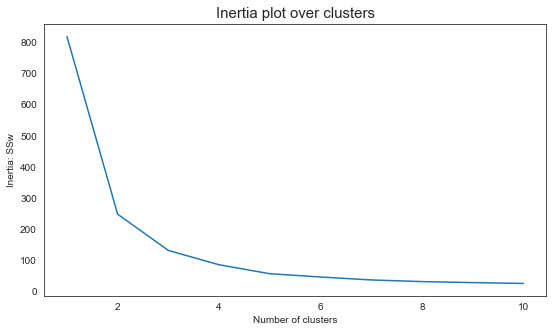

In [9]:
# Defining the number of clusters:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(DF_Clustering[metric_features]) 
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution
    
# The figure:
plt.figure(figsize=(9,5))
#This following step is to make sure that we plot the correct x axis´labels:
plot_df=pd.DataFrame(columns=['x','y'])
plot_df['x']=range(1, 11)
plot_df['y']=inertia

# The inertia plot:
plt.plot('x', 'y',data = plot_df)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

# By looking at the plot we conclude that the best number of clusters would be 3

In [10]:
# Applying Kmeans clustering and getting the cluster' labels of each record
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=1) 
kmeans_labels = kmclust.fit_predict(DF_Clustering[metric_features])
kmeans_labels

array([1, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 1,
       0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 1, 2, 2,
       2, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 1, 2, 1, 0, 2, 0, 2, 0, 2, 2, 0,
       2, 0, 0, 0, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 1, 1, 2, 2, 1, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2,
       0, 0, 2, 1, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 2, 1, 0, 2, 0,
       2, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 0, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0, 2, 0, 0, 1,
       0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 0, 2, 1, 2, 0, 2, 0, 0, 2, 1, 2, 2, 0, 2, 2, 1,
       1, 0, 0, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 0, 1,
       2, 2, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0,

In [11]:
# Calculating the mean of our metric features for each cluster
df_concat = DF_Clustering.copy()
df_concat['k_means_labels'] = kmeans_labels

df_final_kmeans = df_not_standardized.loc[df_concat.index,:]
df_final_kmeans = pd.concat([DF_Clustering[metric_features],df_final_kmeans],axis=1)

df_final_kmeans['k_means_labels']=kmeans_labels

#we also want to compare the clusters with the population:
aux_merge=df_final_kmeans[metric_features].mean()
aux_merge.name='Population'

df_ = pd.concat([df_final_kmeans[metric_features+['k_means_labels']].groupby('k_means_labels').mean(),pd.DataFrame(aux_merge).T])
df_.T

,0,1,2,Population
Sell-out units,-0.685679,1.972460,0.176509,-1.678874e-16
Sell-out units,1.829218,3.068291,2.231121,2.148842e+00
Sell-out values,-0.698677,1.981374,0.192442,-7.094596e-17
Sell-out values,2933.469355,5005.615367,3622.459269,3.473668e+03


In [12]:
# Number of records in each cluster:
df_final_kmeans['k_means_labels'].value_counts()

0    211
2    138
1     61
Name: k_means_labels, dtype: int64

In [13]:
#rename some columns names
df_final_kmeans.columns =['Sell-out units', 'Sell-out values','Sell-out units not standardized','Sell-out values not standardized','k_means_labels']
df_final_kmeans.head()

,Sell-out units,Sell-out values,Sell-out units not standardized,Sell-out values not standardized,k_means_labels
Point-of-Sale_ID,,,,,
1,2.257118,2.160122,3.200982,5143.818679,1
2,0.050218,0.081430,2.172251,3536.627392,2
3,0.099591,0.455605,2.195266,3825.930259,2
4,-0.159028,-0.246901,2.074713,3282.771117,2
5,-0.687694,-0.754529,1.828279,2890.286133,0


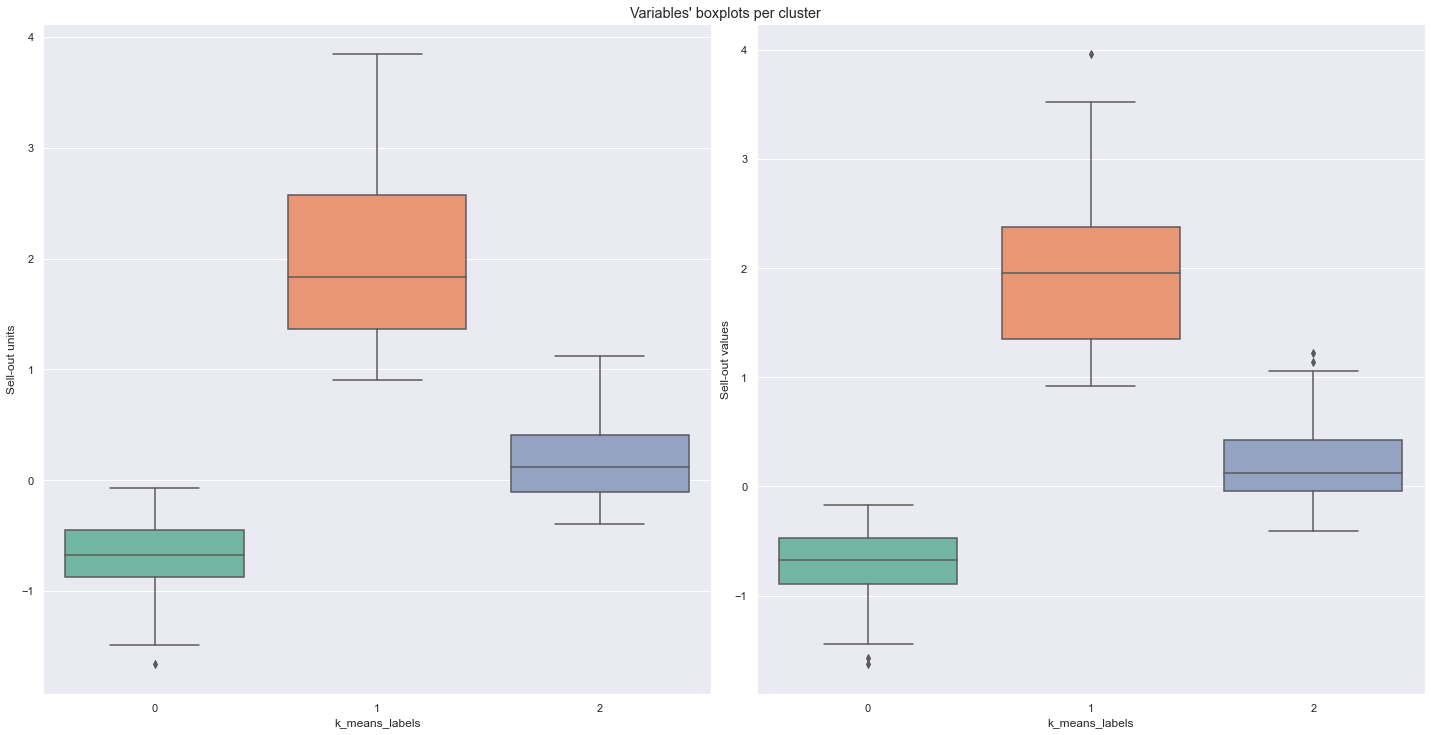

In [14]:
# Visual Analysis of the metric features´ results :
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1,2, figsize=(20,10))
fig.tight_layout()
# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x="k_means_labels", y=feat, data=df_final_kmeans,ax=ax,palette="Set2")

# Layout
# Add a centered title to the figure:
title = "Variables' boxplots per cluster"
plt.suptitle(title, y=1)
plt.show()

In [15]:
# R^2
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_concat[metric_features])  # get total sum of squares
ssw_labels = df_concat[metric_features + ["k_means_labels"]].groupby(by='k_means_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.8395313481878298

<AxesSubplot:xlabel='Sell-out units', ylabel='Sell-out values'>

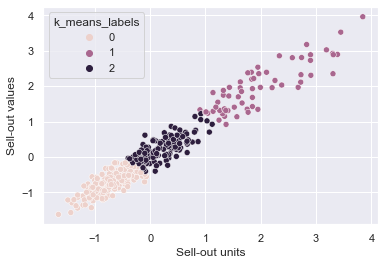

In [16]:
# representation of the clusters on metric features:
sns.scatterplot(x="Sell-out units", y="Sell-out values",hue="k_means_labels",data=df_final_kmeans)

#### Kmeans for a big k + Hierarchical Clustering

Because we have a lot of observations, we are going to perform first the kmeans with a big k in order to reduce the number of observations so we can then apply the hierarchical clustering

Defining  K = 400 

In [17]:
kmclust = KMeans(n_clusters=400, init='k-means++', n_init=15, random_state=1,n_jobs=-1) #random_state=1
big_k_kmeans_labels = kmclust.fit_predict(DF_Clustering[metric_features])
# big_k_kmeans_labels

In [18]:
# Reduced Observations:
df_concat_big_k = DF_Clustering.copy()
df_concat_big_k['big_k_means_labels'] = big_k_kmeans_labels

reduced_obs_df = df_concat_big_k.groupby('big_k_means_labels').mean() # getting the clusters centers, which now are my new
                                                                    # observations to be used for the HC, same results as if I
                                                                    #were to use kmclust.cluster_centers_ to get them
reduced_obs_df # Df we are going to use for the hierarchical clustering

,Sell-out units,Sell-out values
big_k_means_labels,,
0,-0.317011,-0.165676
1,1.651999,1.848202
2,-0.761767,-1.093537
3,0.382855,0.604933
4,3.844036,3.960388
...,...,...
395,-0.120048,-0.345844
396,-0.640645,-0.908547
397,-0.702781,-0.548506


#### Hierarchical Clustering

Choosing linkage method:

In [19]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.shape[0] - 1))  # =some of squares total if we pass all data, and sum of squares wwithin if 
                                                                                                         # we pass the clusters
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) #get cluster labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

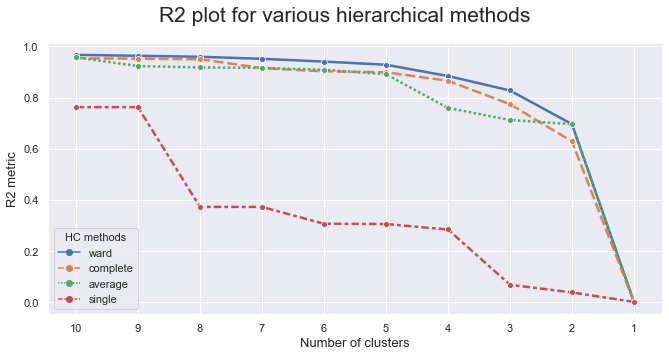

In [20]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=reduced_obs_df[metric_features], link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

# clearly by looking at the R^2 value for the different linkage methods the ward is the best one

Defining the number of clusters

In [21]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit(reduced_obs_df[metric_features])


AgglomerativeClustering(distance_threshold=0, n_clusters=None)

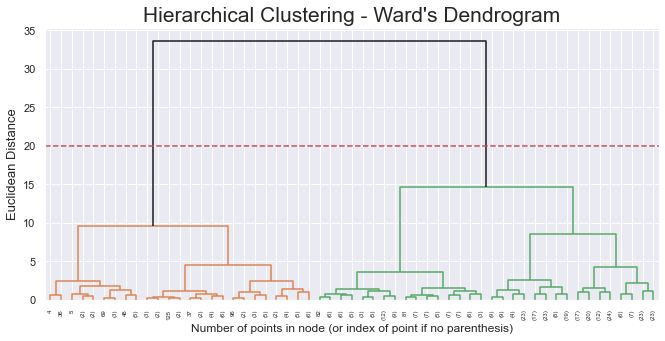

In [22]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 20
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [23]:
# 2 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc3lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=3)
hc3_labels = hc3lust.fit_predict(reduced_obs_df[metric_features])

In [24]:
# Characterizing the 2 clusters
df_concat = pd.concat((reduced_obs_df[metric_features], pd.Series(hc3_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,Sell-out units,Sell-out values
labels,,
0,1.895688,1.912465
1,-0.601154,-0.609837
2,0.291167,0.303598


In [25]:
aux_dictionary=df_concat['labels'].to_dict()
df_concat_big_k['labels']=df_concat_big_k['big_k_means_labels'].map(aux_dictionary)
df_concat_big_k['labels']

Point-of-Sale_ID
1      0
2      2
3      2
4      1
5      1
      ..
406    2
407    0
408    2
409    2
410    0
Name: labels, Length: 410, dtype: int64

In [26]:
df_concat_big_k['labels'].value_counts()

1    253
2     91
0     66
Name: labels, dtype: int64

In [27]:
# ANALYSING THE HC CLUSTERING SOLUTION FOR THE METRIC FEATURES:
df_final_hc = df_not_standardized.loc[df_concat_big_k.index,:] # getting the original values of our variables to interpret them
                                                            # and making sure the observations are the same
df_final_hc['labels']=df_concat_big_k['labels'].copy()
df_final_hc[metric_features+['labels']].groupby('labels').mean()

,Sell-out units,Sell-out values
labels,,
0,3.032504,4952.336437
1,1.869502,3004.209787
2,2.284573,3706.424939


###### Visual Analysis of the metric features´ results of the kmeans+HC


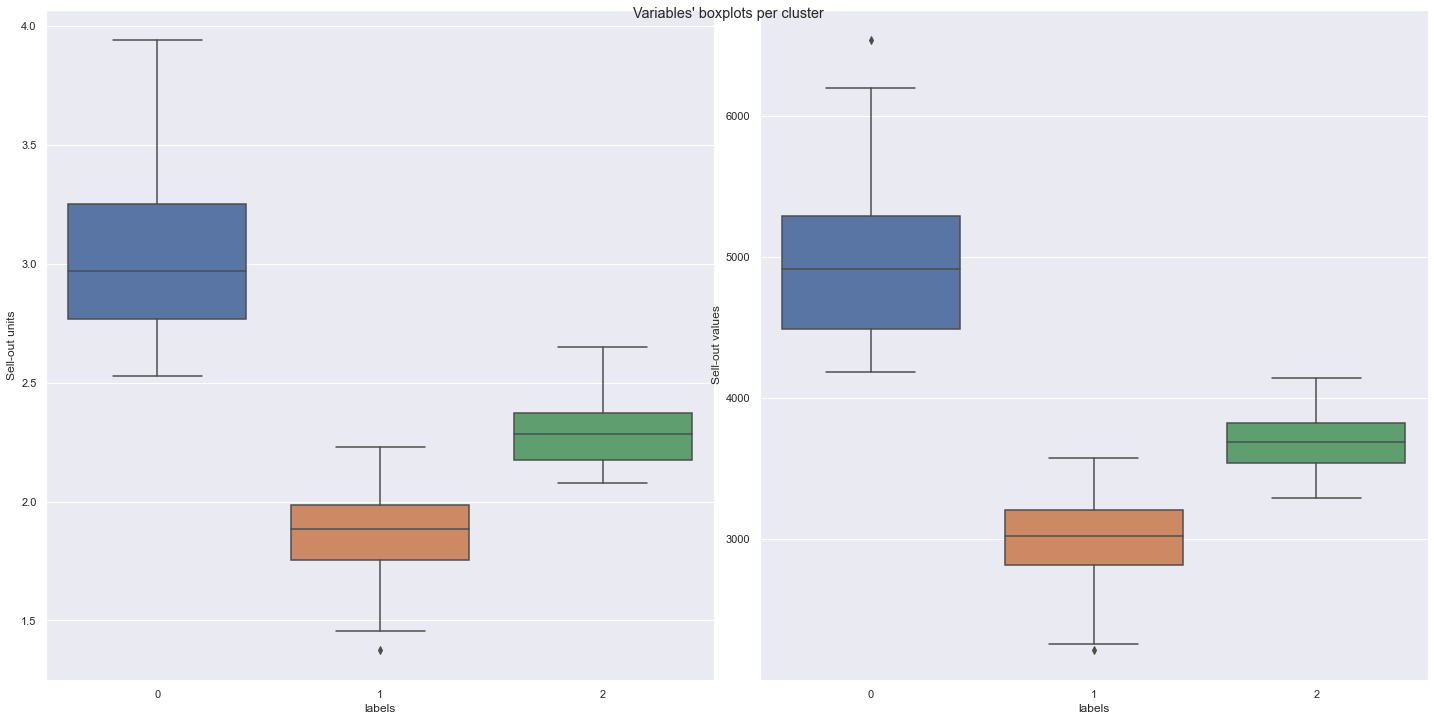

In [28]:
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1,2, figsize=(20,10))
fig.tight_layout()
# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x="labels", y=feat, data=df_final_hc,ax=ax)

# Layout
# Add a centered title to the figure:
title = "Variables' boxplots per cluster"
plt.suptitle(title)
plt.show()

In [29]:
# using R^2

sst = get_ss(df_concat_big_k[metric_features])  # get total sum of squares
ssw_labels = df_concat_big_k[metric_features + ["labels"]].groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.8276439576252952

<AxesSubplot:xlabel='Sell-out units', ylabel='Sell-out values'>

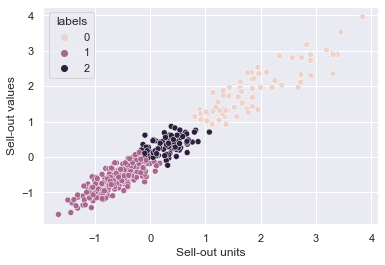

In [30]:
# representation of the clusters on metric features:
sns.scatterplot(x="Sell-out units", y="Sell-out values",hue="labels",data=df_concat_big_k)

####  Density Based Clustering

##### Mean Shift Clustering

In [31]:
bandwidth = estimate_bandwidth(DF_Clustering[metric_features], quantile=0.2, random_state=1, n_jobs=-1)
bandwidth

0.6957357478861773

In [32]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
# bin_seeding if not set to true will take a lot of time to run
ms_labels = ms.fit_predict(DF_Clustering[metric_features])

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 4


In [33]:
# Characterizing the 3 clusters
df_concat_ms = DF_Clustering.copy()
df_concat_ms['ms_labels'] = ms_labels

df_final_ms = df_not_standardized.loc[df_concat_ms.index,:]
df_final_ms = pd.concat([DF_Clustering[metric_features],df_final_ms],axis=1)

df_final_ms['ms_labels']=ms_labels

#we also want to compare the clusters with the population:
aux_merge3=df_final_ms[metric_features].mean()
aux_merge3.name='Population'

pd.concat([df_final_ms[metric_features+['ms_labels']].groupby('ms_labels').mean(),pd.DataFrame(aux_merge3).T])

,Sell-out units,Sell-out units,Sell-out values,Sell-out values
0,-4.410601e-01,1.943245,-4.444971e-01,3129.994538
1,1.121728e+00,2.671728,1.176362e+00,4383.200628
2,2.722305e+00,3.417825,2.575978e+00,5465.347270
3,3.645021e+00,3.847943,3.742600e+00,6367.348915
Population,-1.678874e-16,2.148842,-7.094596e-17,3473.668172


In [34]:
#rename some columns names
df_final_ms.columns =['Sell-out units', 'Sell-out values','Sell-out units not standardized','Sell-out values not standardized','ms_labels']


<AxesSubplot:xlabel='Sell-out units', ylabel='Sell-out values'>

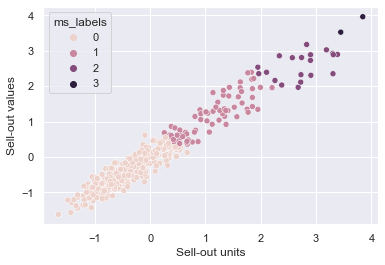

In [35]:
# representation of the clusters on metric features:
sns.scatterplot(x="Sell-out units", y="Sell-out values",hue="ms_labels",data=df_concat_ms)

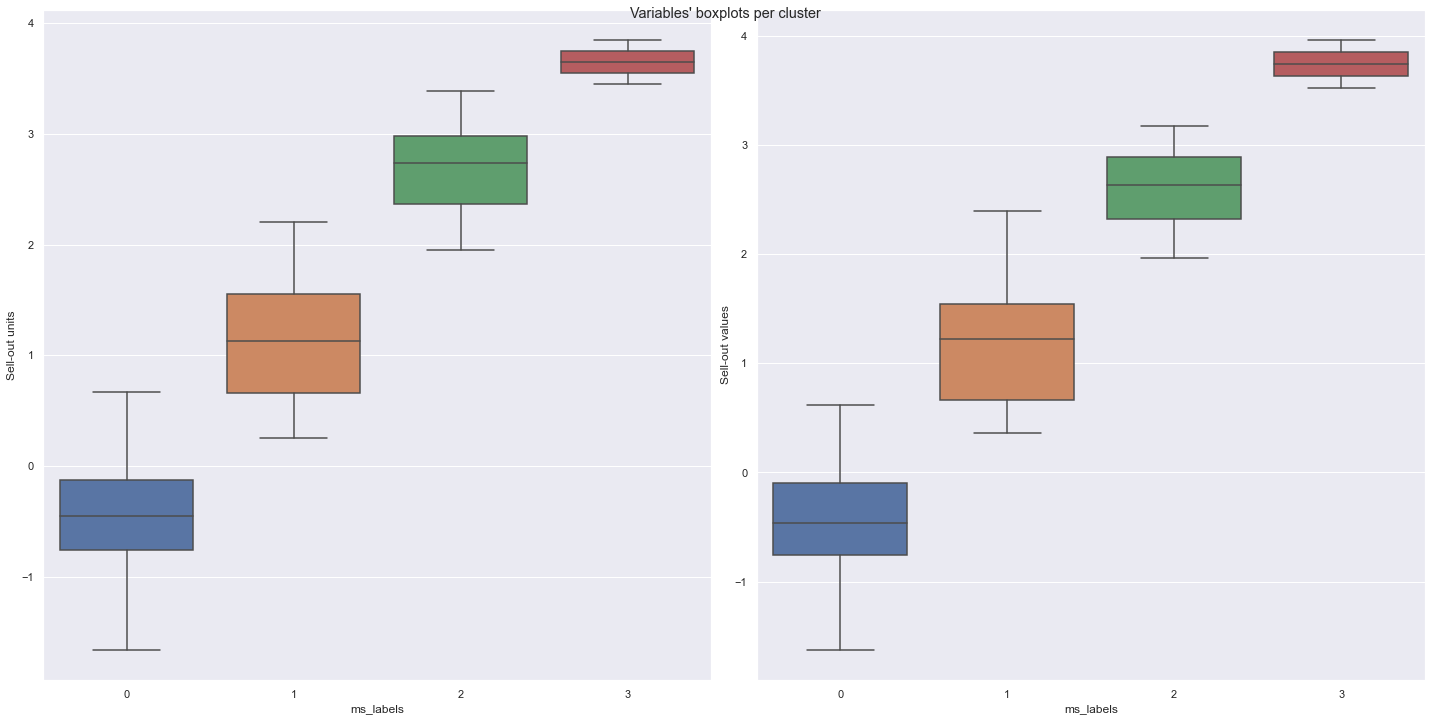

In [36]:
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1,2, figsize=(20,10))
fig.tight_layout()
# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x="ms_labels", y=feat, data=df_final_ms,ax=ax)

# Layout
# Add a centered title to the figure:
title = "Variables' boxplots per cluster"
plt.suptitle(title)
plt.show()

In [37]:
# using R^2

sst = get_ss(df_concat_ms[metric_features])  # get total sum of squares
ssw_labels = df_concat_ms[metric_features + ["ms_labels"]].groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.7867770307378079

##### DBSCAN (Density-based spatial clustering of applications with noise)

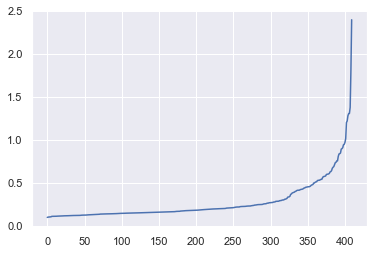

In [38]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(DF_Clustering[metric_features])
distances, _ = neigh.kneighbors(DF_Clustering[metric_features])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [39]:
dbscan = DBSCAN(eps=0.2, min_samples=10, n_jobs=4) 
dbscan_labels = dbscan.fit_predict(DF_Clustering[metric_features])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


In [40]:
# Characterizing the clusters
df_concat_dbscan = DF_Clustering.copy()
df_concat_dbscan['dbscan_labels'] = dbscan_labels

df_final_dbscan = df_not_standardized.loc[df_concat_dbscan.index,:]
df_final_dbscan = pd.concat([DF_Clustering[metric_features],df_final_dbscan],axis=1)

df_final_dbscan['dbscan_labels']=dbscan_labels

#we also want to compare the clusters with the population:
aux_merge4=df_final_dbscan[metric_features].mean()
aux_merge4.name='Population'

pd.concat([df_final_dbscan[metric_features+['dbscan_labels']].groupby('dbscan_labels').mean(),pd.DataFrame(aux_merge4).T])



,Sell-out units,Sell-out units,Sell-out values,Sell-out values
-1,1.554692e+00,2.873551,1.574006e+00,4690.649051
0,-3.537624e-01,1.983939,-3.581572e-01,3196.750367
Population,-1.678874e-16,2.148842,-7.094596e-17,3473.668172


In [41]:
#rename some columns names
df_final_dbscan.columns =['Sell-out units', 'Sell-out values','Sell-out units not standardized','Sell-out values not standardized','dbscan_labels']

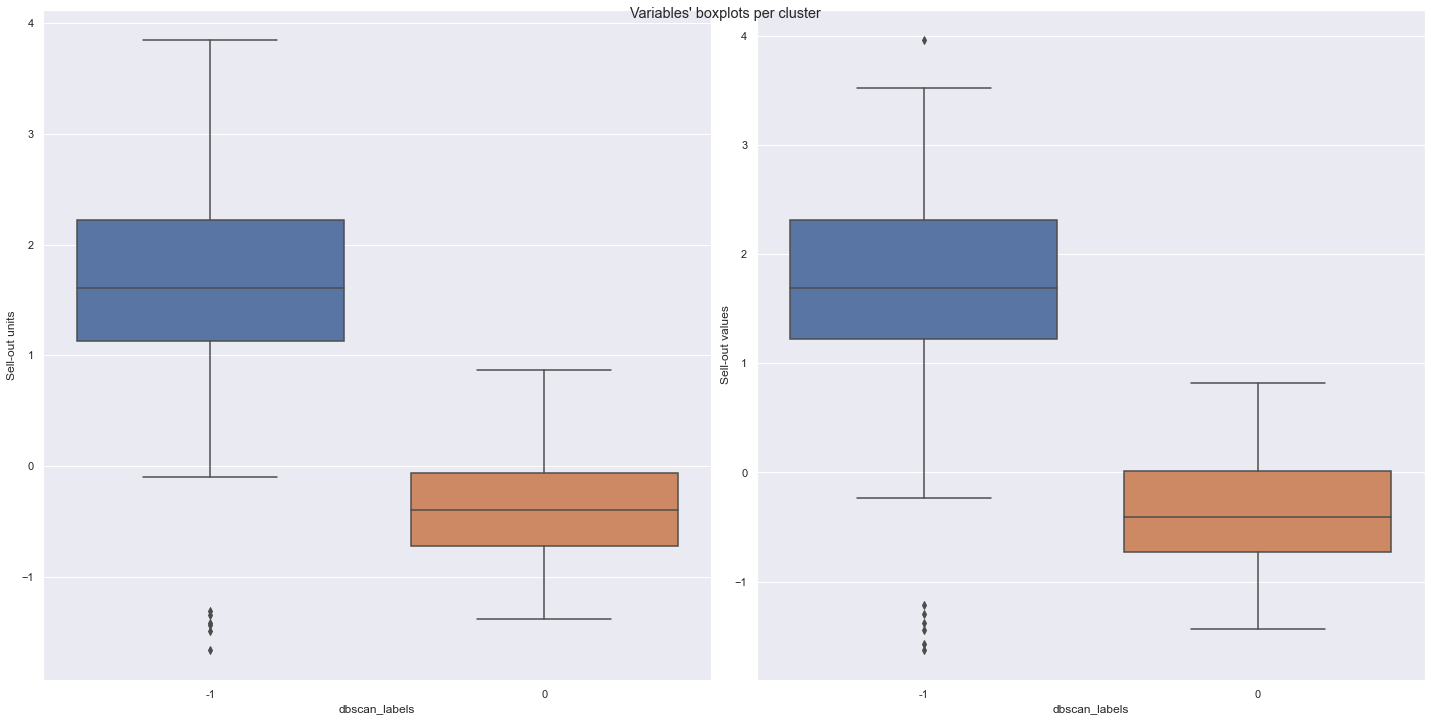

In [42]:
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1,2, figsize=(20,10))
fig.tight_layout()
# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x="dbscan_labels", y=feat, data=df_final_dbscan,ax=ax)

# Layout
# Add a centered title to the figure:
title = "Variables' boxplots per cluster"
plt.suptitle(title)
plt.show()

<AxesSubplot:xlabel='Sell-out units', ylabel='Sell-out values'>

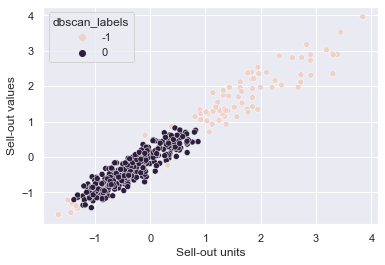

In [43]:
# representation of the clusters on metric features:
sns.scatterplot(x="Sell-out units", y="Sell-out values",hue="dbscan_labels",data=df_concat_dbscan)

In [44]:
# using R^2

sst = get_ss(df_concat_dbscan[metric_features])  # get total sum of squares
ssw_labels = df_concat_dbscan[metric_features + ["dbscan_labels"]].groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.556866675301293

##### Gaussian Mixture Model

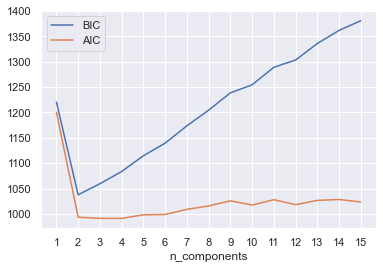

In [45]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(DF_Clustering[metric_features])
          for n in n_components]

bic_values = [m.bic(DF_Clustering[metric_features]) for m in models]
aic_values = [m.aic(DF_Clustering[metric_features]) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()


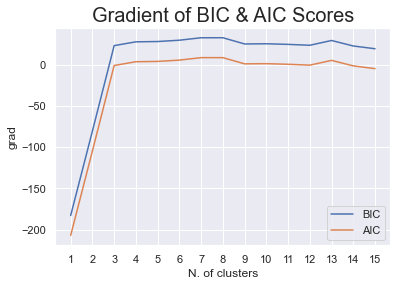

In [46]:
plt.errorbar(n_components, np.gradient(bic_values), label='BIC')
plt.errorbar(n_components, np.gradient(aic_values), label='AIC')
plt.title("Gradient of BIC & AIC Scores", fontsize=20)
plt.xticks(n_components)
plt.xlabel("N. of clusters")
plt.ylabel("grad")
plt.legend()

In [47]:
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(DF_Clustering[metric_features])
df_concat_gmm = pd.concat([DF_Clustering[metric_features], pd.Series(gmm_labels, index=DF_Clustering.index, name="gmm_labels")], axis=1)

In [48]:
df_concat_gmm['gmm_labels'].value_counts()


1    226
0    116
2     68
Name: gmm_labels, dtype: int64

In [49]:
# ANALYSING THE GMM CLUSTERING SOLUTION FOR THE METRIC FEATURES:
df_final_gmm = df_not_standardized.loc[df_concat_gmm.index,:]
df_final_gmm['gmm_labels']=df_concat_gmm['gmm_labels'].copy()
df_final_gmm[metric_features+['gmm_labels']].groupby('gmm_labels').mean()

,Sell-out units,Sell-out values
gmm_labels,,
0,2.230769,3631.184405
1,1.845734,2955.645818
2,3.016474,4926.626538


<AxesSubplot:xlabel='Sell-out units', ylabel='Sell-out values'>

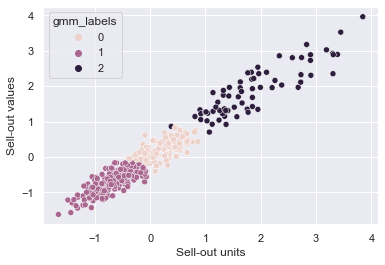

In [50]:
# representation of the clusters on metric features:
sns.scatterplot(x="Sell-out units", y="Sell-out values",hue="gmm_labels",data=df_concat_gmm)


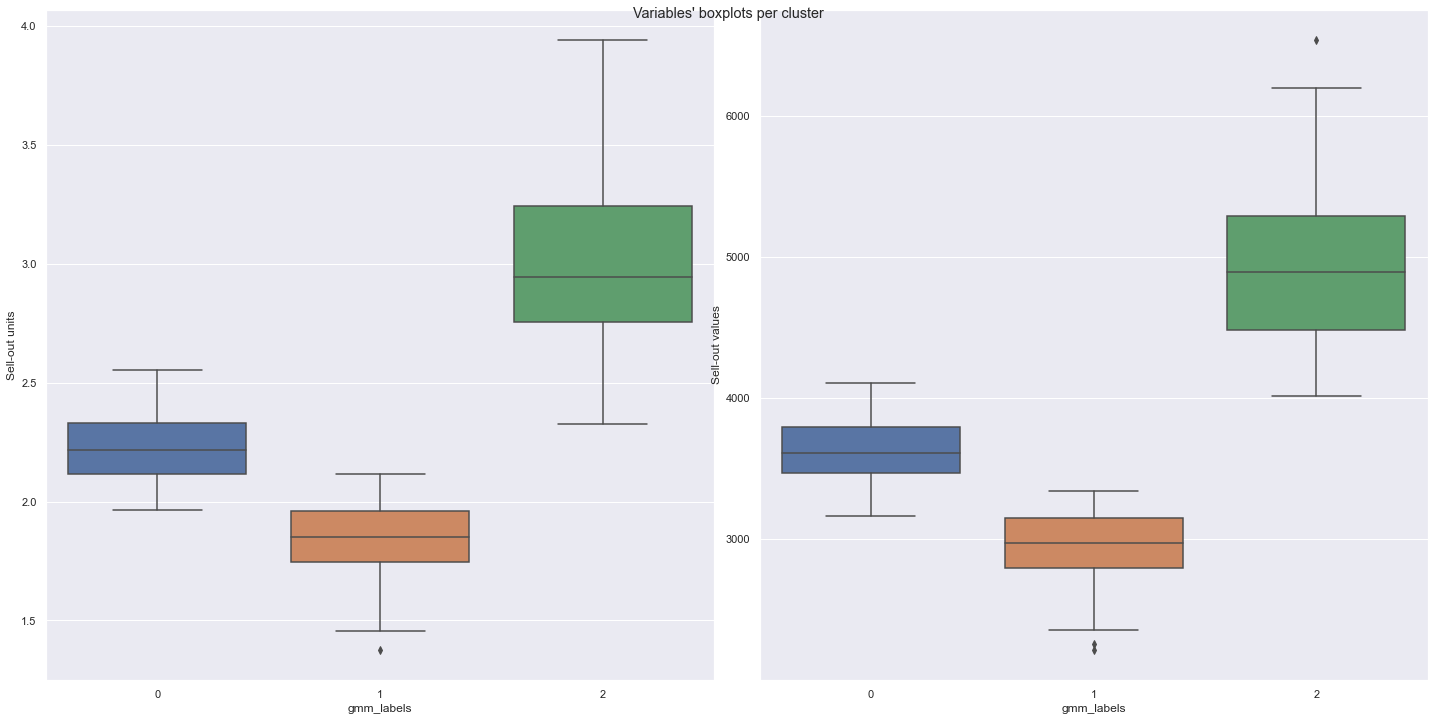

In [51]:
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(1,2, figsize=(20,10))
fig.tight_layout()
# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x="gmm_labels", y=feat, data=df_final_gmm,ax=ax)

# Layout
# Add a centered title to the figure:
title = "Variables' boxplots per cluster"
plt.suptitle(title)
plt.show()

In [52]:
# using R^2

sst = get_ss(df_concat_gmm[metric_features])  # get total sum of squares
ssw_labels = df_concat_gmm[metric_features + ["gmm_labels"]].groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.8306400375650941

### Point-of-Sales Clustering by Product preference


In [8]:
ProductCount = df.groupby(['Point-of-Sale_ID', 'ProductName_ID'])['Sell-out units'].sum().to_frame() 
ProductCount.columns=['total Sell-out units']
ProductCount

total Sell-out units
Point-of-Sale_ID ProductName_ID                      
1                4                                 12
                 5                                 17
                 6                                 20
                 14                               612
                 15                                19
...                                               ...
410              2841                             712
                 2845                            2879
                 2846                            2044
                 2847                            4831
                 2849                               2

[467154 rows x 1 columns]

In [9]:
table = pd.pivot_table(ProductCount, values='total Sell-out units', index=['Point-of-Sale_ID'],
                    columns=['ProductName_ID'])

In [10]:
table.fillna(0,inplace=True)
table.head()

ProductName_ID    1     2     3     4     5      6     7     8     9     11    \
Point-of-Sale_ID                                                                
1                  0.0   0.0   0.0  12.0  17.0   20.0   0.0   0.0   0.0   0.0   
2                  0.0   0.0   1.0  10.0   2.0   19.0   0.0   0.0   0.0   0.0   
3                  0.0   1.0   1.0   4.0   3.0    3.0   0.0   0.0   4.0   0.0   
4                  0.0   5.0  20.0  57.0  13.0  145.0   1.0   1.0   4.0   6.0   
5                  0.0   0.0   3.0   0.0   0.0    4.0   0.0   1.0   2.0   0.0   

ProductName_ID     14    15     17    18    19      21     25    26      27    \
Point-of-Sale_ID                                                                
1                 612.0  19.0  217.0   8.0   0.0  5983.0  235.0   0.0  1040.0   
2                 404.0  34.0   45.0   0.0   0.0  1056.0   15.0   0.0   184.0   
3                 244.0  17.0  192.0   0.0   4.0  4855.0  263.0   0.0   115.0   
4                 179.0  43.0  251.0   6.0   1.0  3627.0  125.0   0.0   480.0   
5                  16.0   4.0   36.0   0.0   0.0  1751.0   38.0   0.0   419.0   

ProductName_ID    28    29    30    31     33     34     35    36     37    \
Point-of-Sale_ID                                                             
1                  0.0   0.0   0.0   0.0  139.0  378.0    0.0   0.0   71.0   
2                  0.0   0.0   0.0   0.0    1.0   21.0  122.0   0.0  365.0   
3                  0.0   0.0   0.0   0.0   47.0   73.0   16.0   0.0  143.0   
4                  1.0   2.0   0.0   0.0    0.0  369.0   61.0   4.0  450.0   
5                  0.0   0.0   0.0   0.0    0.0    2.0    1.0   0.0   91.0   

ProductName_ID      38     39    40     41    42    43    45    46    47    \
Point-of-Sale_ID                                                             
1                 1324.0  156.0   0.0   37.0   0.0   0.0  18.0   0.0   0.0   
2                   18.0  394.0   0.0   28.0   0.0   3.0   0.0   0.0   0.0   
3                 2264.0  159.0  17.0  752.0   1.0   0.0   0.0   0.0   0.0   
4                 1442.0  882.0   0.0  110.0   0.0   5.0   3.0   0.0   0.0   
5                  311.0  120.0   0.0  167.0   0.0   3.0   1.0   0.0   0.0   

ProductName_ID    48    49    50    51    52    53      55    56     57    \
Point-of-Sale_ID                                                            
1                  2.0  22.0   0.0   0.0   0.0   0.0  3190.0  30.0  108.0   
2                  0.0  18.0   0.0   0.0   0.0  24.0  2151.0  11.0  119.0   
3                  0.0  47.0   0.0   1.0   0.0   0.0  3042.0  10.0   12.0   
4                 28.0  33.0   0.0   0.0   0.0  22.0  4341.0  55.0   90.0   
5                  0.0  19.0   0.0   0.0   0.0  15.0  2343.0   9.0   10.0   

ProductName_ID     58    59    60    62    63    64    65    66    67    68    \
Point-of-Sale_ID                                                                
1                 132.0   0.0   0.0   0.0   0.0   7.0  15.0   0.0   2.0  42.0   
2                 209.0   0.0   2.0   0.0  12.0   1.0  10.0   1.0   4.0   0.0   
3                  17.0   0.0   0.0   0.0  36.0   1.0  14.0   0.0  12.0   9.0   
4                  58.0   0.0   9.0   0.0  49.0  55.0  18.0  28.0  36.0   2.0   
5                   2.0   0.0   0.0   0.0  29.0  10.0  29.0   0.0   9.0   0.0   

ProductName_ID    72    73    74     76      78     80     84    85    86    \
Point-of-Sale_ID                                                              
1                 22.0  10.0   2.0  198.0  2708.0    2.0   91.0   0.0  64.0   
2                  1.0  10.0  11.0   45.0  1056.0  133.0  111.0   0.0   0.0   
3                  1.0   3.0   1.0  125.0  4442.0   42.0   28.0   0.0   8.0   
4                  2.0  14.0  16.0  227.0  1832.0  271.0   12.0   0.0   0.0   
5                  0.0   2.0   2.0   95.0   842.0   32.0    1.0   0.0   0.0   

ProductName_ID    87     88     90    91      93     94    95    97    98    \
Point-of-Sale_ID             

###### Scalling our data

In [11]:
scaler = MinMaxScaler()
scaler.fit(table)
scaler.transform(table)

array([[0.        , 0.        , 0.        , ..., 0.06818182, 0.1840796 ,
        0.12121212],
       [0.        , 0.        , 0.00334448, ..., 0.175     , 0.13930348,
        0.00606061],
       [0.        , 0.01754386, 0.00334448, ..., 0.61136364, 0.        ,
        0.26060606],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01754386, 0.00334448, ..., 0.        , 0.00995025,
        0.        ]])

##### Dimensionality Reduction on the metric features using PCA

In [12]:
#PCA
pca = PCA()
pca_feat = pca.fit_transform(table)
var_explained = pca.explained_variance_ratio_.cumsum()
var_explained = var_explained*100 #percentage

# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
).head(20)
# By pearson´s rule (retain 80% of the variance) ->>>> we should keep 20 PC
# according to the Scree Plot we should keep 3PC
# however, we decided to keep 11 PC´s  -> retain 70% of the variance

,Eigenvalue,Difference,Proportion,Cumulative
1,2.373431e+08,0.000000e+00,0.292919,0.292919
2,7.666194e+07,-1.606812e+08,0.094613,0.387531
3,5.025144e+07,-2.641049e+07,0.062018,0.449550
4,4.595253e+07,-4.298916e+06,0.056713,0.506262
5,3.854191e+07,-7.410619e+06,0.047567,0.553829
6,3.020815e+07,-8.333760e+06,0.037282,0.591111
7,2.313115e+07,-7.076993e+06,0.028547,0.619658
8,1.884975e+07,-4.281402e+06,0.023264,0.642922
9,1.812981e+07,-7.199440e+05,0.022375,0.665297
10,1.480287e+07,-3.326933e+06,0.018269,0.683566


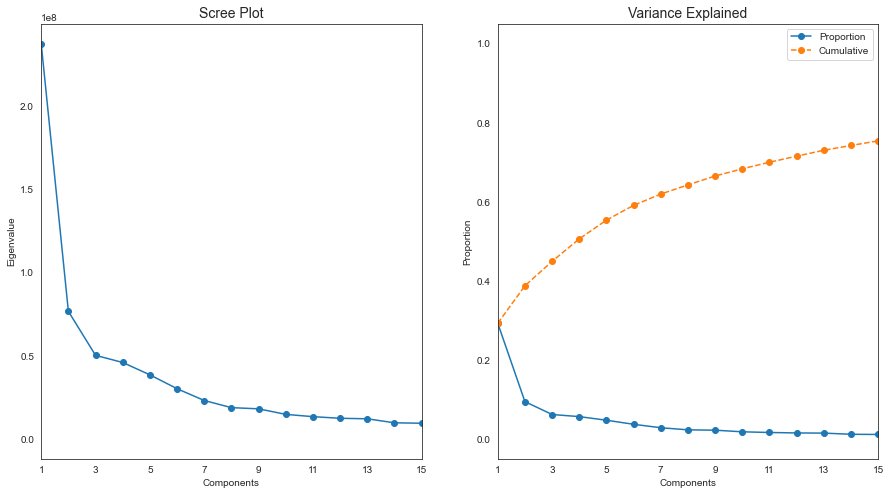

In [13]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, 15, 2))
ax1.set_xlim([0,14])
ax1.set_xticklabels(range(1, 16, 2))
ax2.set_xticks(range(0, 15, 2))
ax2.set_xticklabels(range(1, 16, 2))
ax2.set_xlim([0,14])
plt.show()

In [14]:
pca = PCA(n_components=11)
pca_feat = pca.fit_transform(table)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=table.index, columns=pca_feat_names)
pca_df.reset_index(inplace=True)
pca_df

,Point-of-Sale_ID,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1,9428.645087,456.937185,-14665.471360,10114.757060,-3715.302819,3460.190129,1759.976482,-3005.587869,329.076725,-3.666389,288.608875
1,2,-7058.485678,-7196.790036,-4593.268120,5963.891716,-5344.678415,-874.467601,-1453.270588,-2336.356075,4137.591731,-1456.867357,-1136.572740
2,3,5229.663330,-3704.171399,-4367.506348,10758.250065,932.921769,-6363.702889,11911.016699,-9759.550886,10041.969147,2188.823077,6276.667849
3,4,17051.535310,-3492.051979,5874.395777,9758.706313,7614.520947,-2438.913087,-2061.342389,2018.962757,6505.072753,-2173.208327,-342.392696
4,5,-3155.939638,-6129.506856,-5767.171109,9490.123328,-5312.821581,-1023.573115,-3341.536602,-636.085768,4247.594140,2022.076647,187.479069
...,...,...,...,...,...,...,...,...,...,...,...,...
405,406,3737.775277,37348.871475,-20048.571886,-1125.374007,-7528.210396,13169.019897,3398.800030,-433.511923,19.849653,3752.105685,-2400.394902
406,407,25199.639385,35084.113908,12293.683569,-5348.439013,-20524.875376,7851.510474,9490.933434,-5304.796103,3586.903830,10827.922744,-4135.971566
407,408,2274.216678,32003.307770,-6492.888470,-7909.266189,-15520.335598,7005.724556,1431.711009,-766.960093,2124.753068,6953.551929,-3305.096951
408,409,-1186.278408,14417.904247,6558.582325,-13382.000776,-12870.878848,-356.058912,6106.877275,7397.544802,6306.468521,7268.198012,-7779.782425


In [15]:
pc_features = pca_df.columns[pca_df.columns.str.startswith('PC')].tolist()

#### K-Means over the Principal Components

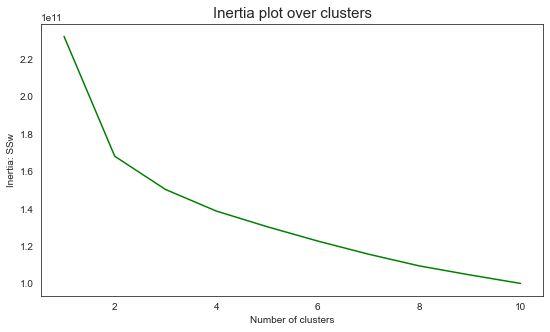

In [16]:
# Defining the number of clusters:
range_clusters = range(1, 11)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(pca_df) 
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution
    
# The figure:
plt.figure(figsize=(9,5))
#This following step is to make sure that we plot the correct x axis'labels:
plot_df=pd.DataFrame(columns=['x','y'])
plot_df['x']=range(1, 11)
plot_df['y']=inertia

# The inertia plot:
plt.plot('x', 'y',data = plot_df,color='green')
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

# By looking at the plot we conclude that the best number of clusters would be 2

In [17]:
# Applying Kmeans clustering and getting the cluster' labels of each record
number_clusters = 2
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(pca_df)# Characterizing the final clusters
km_labels

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,

In [18]:
df_concat_kmeans = pd.concat((pca_df, pd.Series(km_labels, name='labels')), axis=1)
df_concat_kmeans

,Point-of-Sale_ID,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,labels
0,1,9428.645087,456.937185,-14665.471360,10114.757060,-3715.302819,3460.190129,1759.976482,-3005.587869,329.076725,-3.666389,288.608875,1
1,2,-7058.485678,-7196.790036,-4593.268120,5963.891716,-5344.678415,-874.467601,-1453.270588,-2336.356075,4137.591731,-1456.867357,-1136.572740,0
2,3,5229.663330,-3704.171399,-4367.506348,10758.250065,932.921769,-6363.702889,11911.016699,-9759.550886,10041.969147,2188.823077,6276.667849,1
3,4,17051.535310,-3492.051979,5874.395777,9758.706313,7614.520947,-2438.913087,-2061.342389,2018.962757,6505.072753,-2173.208327,-342.392696,1
4,5,-3155.939638,-6129.506856,-5767.171109,9490.123328,-5312.821581,-1023.573115,-3341.536602,-636.085768,4247.594140,2022.076647,187.479069,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,406,3737.775277,37348.871475,-20048.571886,-1125.374007,-7528.210396,13169.019897,3398.800030,-433.511923,19.849653,3752.105685,-2400.394902,1
406,407,25199.639385,35084.113908,12293.683569,-5348.439013,-20524.875376,7851.510474,9490.933434,-5304.796103,3586.903830,10827.922744,-4135.971566,1
407,408,2274.216678,32003.307770,-6492.888470,-7909.266189,-15520.335598,7005.724556,1431.711009,-766.960093,2124.753068,6953.551929,-3305.096951,0
408,409,-1186.278408,14417.904247,6558.582325,-13382.000776,-12870.878848,-356.058912,6106.877275,7397.544802,6306.468521,7268.198012,-7779.782425,0


In [19]:
table.insert(0, 'labels', df_concat_kmeans['labels'])

In [20]:
# Number of records in each cluster:
df_concat_kmeans['labels'].value_counts()

0    251
1    159
Name: labels, dtype: int64

Text(0.5, 1.0, '2 Clusters')

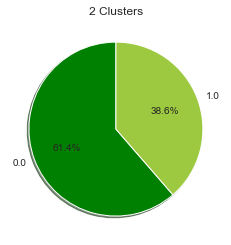

In [22]:
market = table.labels.value_counts()
color = ["#008000","#9cc93f","#6b8e23"]
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90, colors=color)
plt.title('2 Clusters')

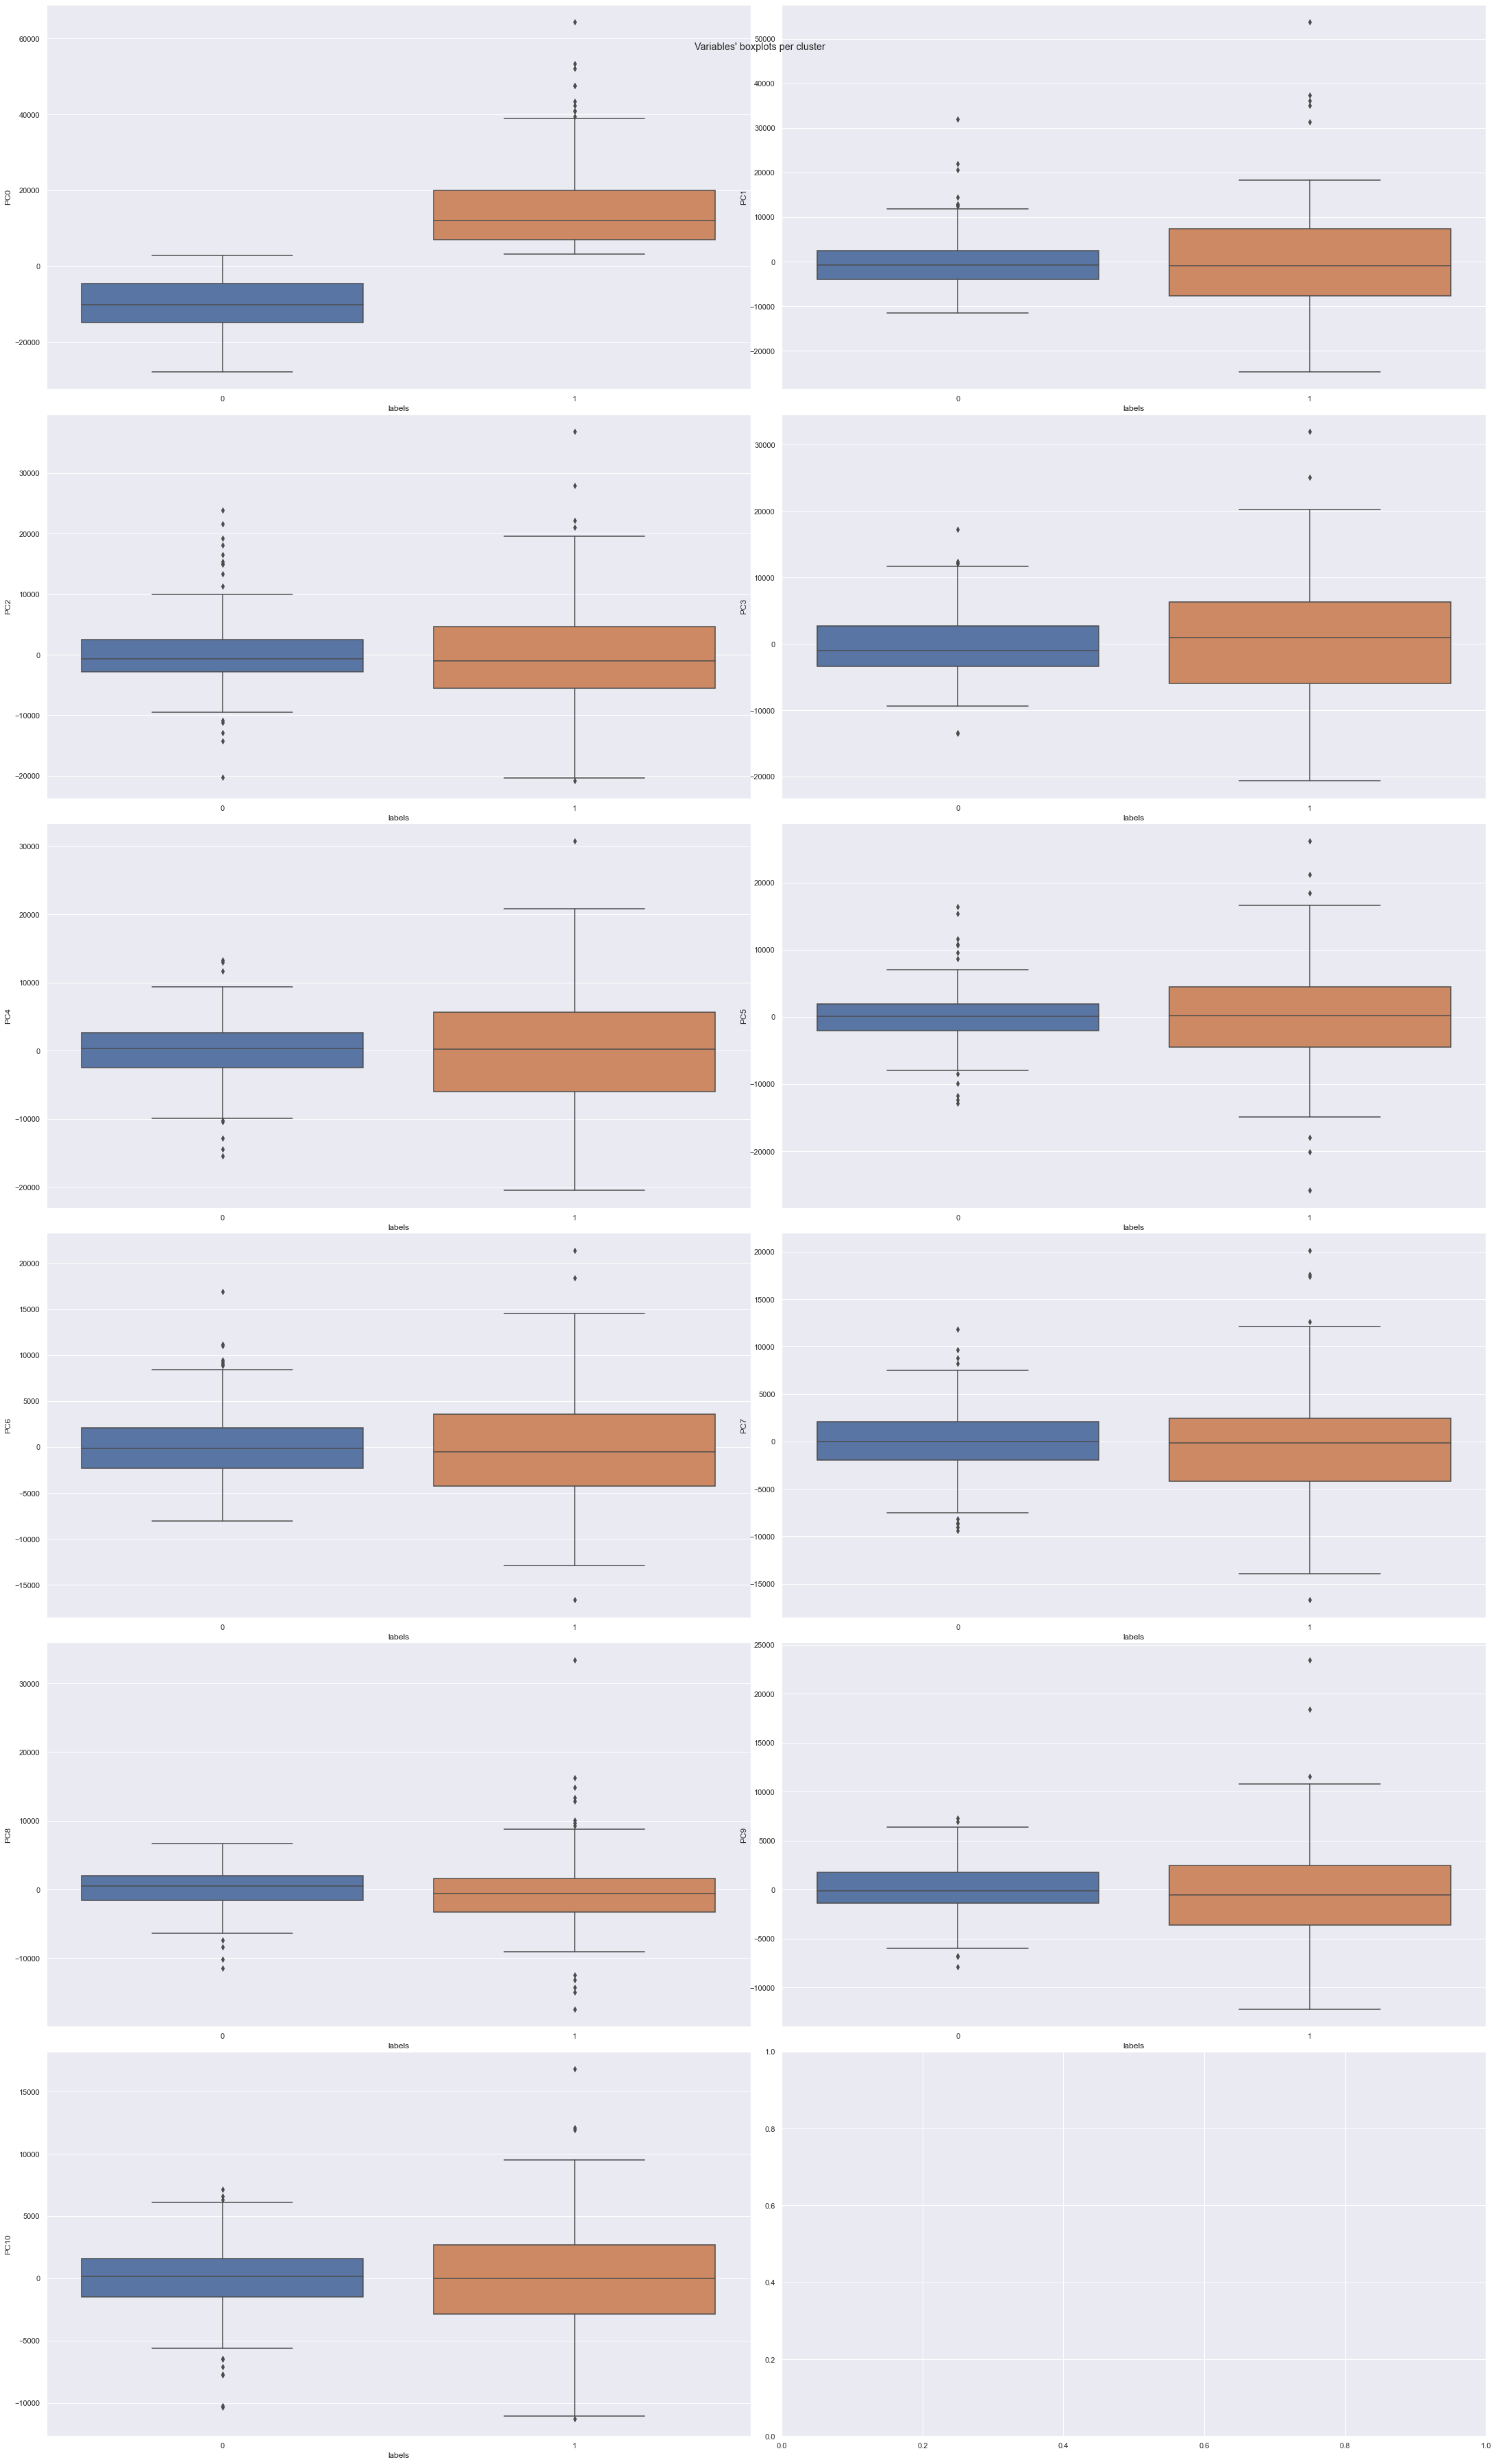

In [23]:
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(6,2, figsize=(30,50))
fig.tight_layout()
# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), pc_features):
    sns.boxplot(x="labels", y=feat, data=df_concat_kmeans,ax=ax)

# Layout
# Add a centered title to the figure:
title = "Variables' boxplots per cluster"
plt.suptitle(title)
plt.show()

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

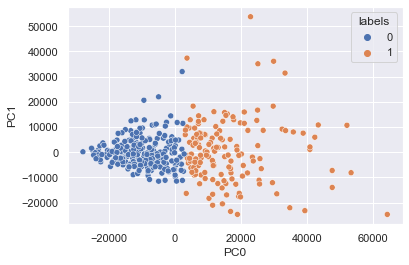

In [24]:
# representation of the clusters on the first 2 PC´s:
sns.scatterplot(x="PC0", y="PC1",hue="labels",data=df_concat_kmeans)

In [25]:
table.groupby('labels').mean()

ProductName_ID,1,2,3,4,5,6,7,8,9,11,14,15,17,18,19,21,25,26,27,28,29,30,31,33,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,55,56,57,58,59,60,62,63,64,65,66,67,68,72,73,74,76,78,80,84,85,86,87,88,90,91,93,94,95,97,98,99,101,103,104,105,106,107,108,111,112,113,114,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,166,169,170,171,172,174,176,177,178,179,181,182,184,185,186,187,188,189,190,191,193,195,196,197,198,199,200,201,202,203,204,205,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,224,225,226,227,228,229,231,234,235,236,237,239,240,241,244,246,247,248,249,250,251,252,253,254,255,256,257,258,259,262,263,264,265,266,268,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,307,310,311,312,313,315,316,317,318,319,321,324,326,327,328,329,331,333,334,335,337,338,340,341,342,343,346,348,349,353,354,355,356,357,363,364,367,368,369,370,371,372,373,374,375,377,378,379,381,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,401,402,403,404,405,406,407,408,409,411,412,413,416,417,418,419,420,422,424,425,426,430,431,434,435,436,438,439,441,442,443,444,445,446,447,449,451,452,453,454,455,457,458,459,460,462,463,464,465,467,468,470,471,472,473,474,475,476,477,478,480,481,482,483,484,488,489,490,491,492,493,494,495,496,498,500,501,502,503,504,505,506,508,509,511,512,513,515,516,517,518,519,520,521,524,525,526,527,528,530,532,533,534,535,536,537,538,539,541,542,543,544,546,547,548,549,550,551,552,553,555,556,557,558,559,561,563,564,567,568,569,570,571,572,573,575,576,577,578,579,583,584,585,586,587,588,589,591,592,593,594,600,602,604,606,610,611,612,613,615,616,617,618,619,620,621,622,623,624,625,626,627,629,630,631,633,634,635,637,642,643,644,645,646,647,649,650,653,654,656,657,658,659,660,662,664,665,666,667,669,670,671,672,673,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,693,694,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,716,717,719,720,721,722,723,725,727,728,729,730,731,733,735,736,737,738,739,740,741,743,744,745,746,747,748,749,751,752,753,754,757,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,779,780,781,782,783,784,785,786,787,788,789,790,791,793,794,795,796,798,799,801,803,805,806,807,808,809,811,812,814,815,818,819,820,821,823,825,826,827,828,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,885,887,889,890,891,892,893,895,896,897,898,899,900,903,904,906,909,910,911,912,921,922,923,924,925,926,927,930,931,932,933,934,935,936,938,940,942,943,945,947,948,949,950,951,952,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,982,983,984,986,987,988,989,990,991,992,993,994,995,996,997,998,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1033,1034,1035,1036,1038,1039,1041,1042,1043,1045,1046,1047,1048,1049,1050,1051,1052,1053,1054,1055,1056,1059,1060,1061,1062,1063,1064,1065,1066,1068,1069,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1092,1093,1094,1096,1097,1098,1100,1101,1105,1107,1108,1110,1111,1114,1115,1116,1118,1120,1122,1123,1124,1125,1126,1127,1128,1129,1130,1132,1133,1136,1138,1139,1140,1141,1142,1143,1144,1147,1148,1153,1155,1156,1157,1158,1160,1161,1163,1164,1165,1166,1168,1170,1171,1172,1173,1174,1176,1177,1178,1179,1180,1182,1184,1185,1186,1187,1191,1192,1193,1194,1195,1196,1197,1199,1200,1201,1202,1203,1205,1206,1207,1208,1210,1213,1214,1215,1216,1217,1218,1219,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,12

In [28]:
sst = get_ss(df_concat_kmeans)  # get total sum of squares
ssw_labels = df_concat_kmeans.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.2758067234883292

##### Mean Shift Clustering

##### Gaussian Mixture Model

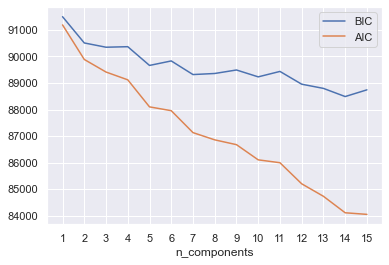

In [72]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(pca_df[pc_features])
          for n in n_components]

bic_values = [m.bic(pca_df[pc_features]) for m in models]
aic_values = [m.aic(pca_df[pc_features]) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()


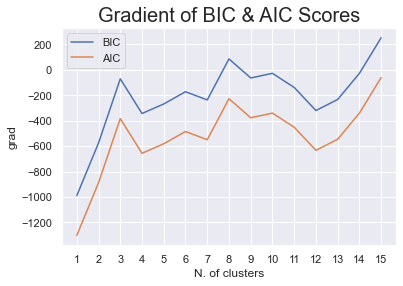

In [73]:
plt.errorbar(n_components, np.gradient(bic_values), label='BIC')
plt.errorbar(n_components, np.gradient(aic_values), label='AIC')
plt.title("Gradient of BIC & AIC Scores", fontsize=20)
plt.xticks(n_components)
plt.xlabel("N. of clusters")
plt.ylabel("grad")
plt.legend()

In [74]:
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(pca_df[pc_features])
df_concat_gmm = pd.concat([pca_df[pc_features], pd.Series(gmm_labels, index=pca_df.index, name="gmm_labels")], axis=1)

In [75]:
df_concat_gmm['gmm_labels'].value_counts()


0    174
1    163
2     73
Name: gmm_labels, dtype: int64

In [76]:
# ANALYSING THE GMM CLUSTERING SOLUTION FOR THE METRIC FEATURES:
df_final_gmm = pca_df.loc[df_concat_gmm.index,:]
df_final_gmm['gmm_labels']=df_concat_gmm['gmm_labels'].copy()
df_final_gmm[pc_features+['gmm_labels']].groupby('gmm_labels').mean()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
gmm_labels,,,,,,,,,,,
0,2718.126175,115.675558,772.736030,4078.031622,89.615703,-113.506658,805.652997,177.247837,-823.819095,-283.172181,568.890536
1,-10973.548655,-2393.321821,-400.592693,-2087.664872,-204.355692,266.982262,-549.735509,-209.379524,549.833567,-499.585079,-530.755406
2,18023.759949,5068.272735,-947.389866,-5058.741480,242.696513,-325.588358,-692.831966,45.037517,735.913027,1790.470237,-170.874275


In [77]:
table.insert(0, 'gmm_labels', df_final_gmm['gmm_labels'])
table.groupby('gmm_labels').mean()

ProductName_ID    labels         1         2          3          4          5  \
gmm_labels                                                                      
0.0             1.225434  0.387283  3.734104  19.549133  21.202312   7.595376   
1.0             0.257669  0.012270  4.085890  22.619632  19.343558   7.184049   
2.0             1.205479  0.054795  4.178082  24.068493  25.945205  10.547945   

ProductName_ID          6         7         8          9        11  \
gmm_labels                                                           
0.0             36.913295  0.421965  0.832370   9.184971  0.156069   
1.0             28.699387  0.638037  0.852761   9.668712  0.030675   
2.0             36.013699  0.643836  0.520548  12.452055  1.547945   

ProductName_ID          14          15          17        18         19  \
gmm_labels                                                                
0.0             524.225434  102.832370  357.560694  3.543353  33.502890   
1.0             507.079755  114.472393  349.926380  3.171779  33.300613   
2.0             583.657534  139.698630  517.520548  4.136986  38.986301   

ProductName_ID           21          25        26          27          28  \
gmm_labels                                                                  
0.0             3786.820809  189.716763  0.011561  448.075145  116.086705   
1.0             4097.404908  193.141104  0.085890  457.484663    1.840491   
2.0             5292.931507  270.260274  0.000000  624.493151   13.397260   

ProductName_ID        29        30        31         33          34  \
gmm_labels                                                            
0.0             0.693642  0.063584  4.346821  14.670520  157.878613   
1.0             0.711656  0.000000  3.079755  18.588957  198.423313   
2.0             0.424658  0.013699  2.123288  22.041096  140.013699   

ProductName_ID          35        36          37          38          39  \
gmm_labels                                                                 
0.0             151.416185  7.601156  635.265896  601.323699  474.369942   
1.0             214.159509  5.276074  569.865031  575.061350  488.018405   
2.0             163.219178  6.041096  771.616438  571.493151  596.191781   

ProductName_ID         40          41        42        43        45        46  \
gmm_labels                                                                      
0.0             12.965318  547.705202  2.780347  7.722543  8.618497  0.508671   
1.0              8.907975  403.950920  2.276074  5.257669  7.515337  0.276074   
2.0              4.931507  467.109589  3.068493  4.547945  8.643836  0.424658   

ProductName_ID        47         48         49        50        51        52  \
gmm_labels                                                                     
0.0             0.000000  17.705202  48.734104  0.005780  2.988439  1.063584   
1.0             0.067485  36.220859  44.134969  0.000000  3.386503  0.895706   
2.0             0.054795  33.876712  58.698630  0.082192  5.438356  1.246575   

ProductName_ID         53           55         56          57          58  \
gmm_labels                                                                  
0.0             11.161850  4282.653179  42.618497  139.797688  143.895954   
1.0             12.441718  3705.981595  36.104294  118.871166  112.386503   
2.0              9.082192  4721.232877  43.465753  163.397260  153.479452   

ProductName_ID         59         60        62         63         64  \
gmm_labels                                                             
0.0             23.069364  28.346821  0.005780  23.427746  22.260116   
1.0             15.460123  20.668712  0.000000  21.036810  22.049080   
2.0             21.465753  34.863014  0.027397  26.739726  35.890411   

ProductName_ID         65        66        67         68        72        73  \
gmm_labels                                                                     
0.0             13.034682  1.9

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

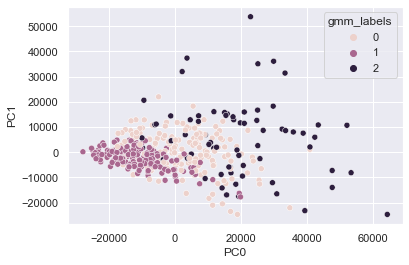

In [78]:
# representation of the clusters on the first 2 PC´s:
sns.scatterplot(x="PC0", y="PC1",hue="gmm_labels",data=df_concat_gmm)

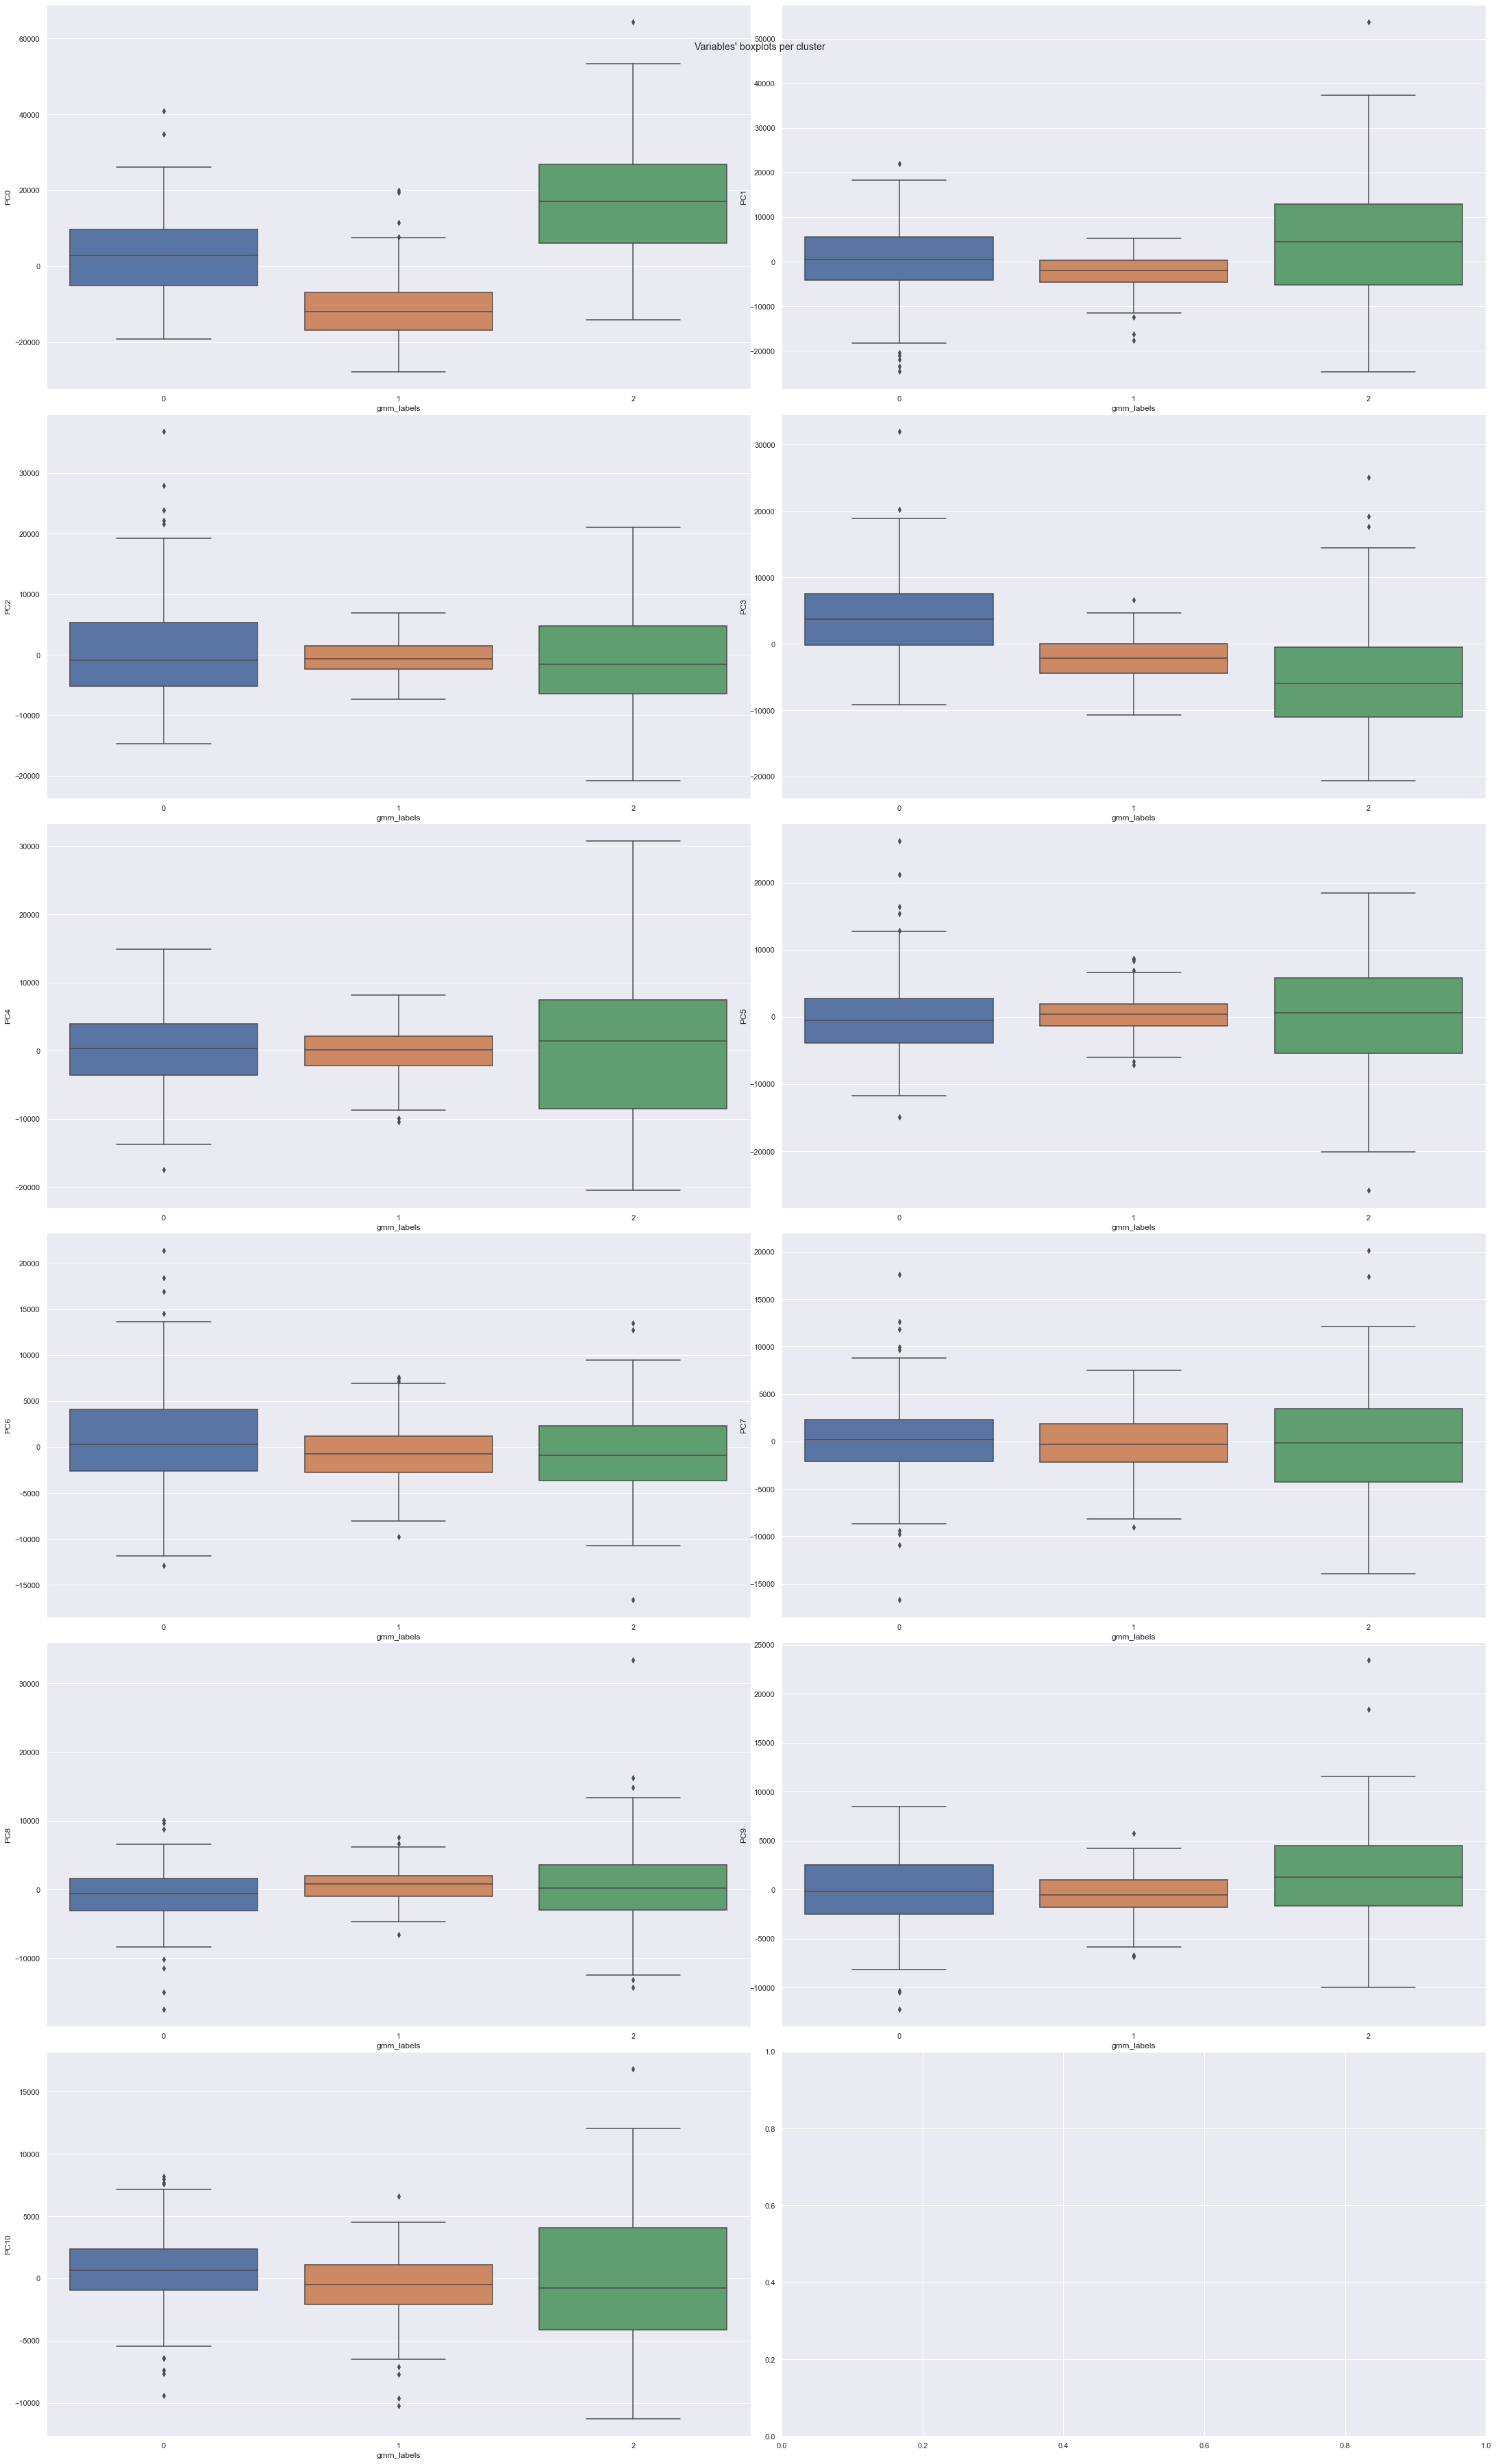

In [79]:
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(6,2, figsize=(30,50))
fig.tight_layout()
# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), pc_features):
    sns.boxplot(x="gmm_labels", y=feat, data=df_final_gmm,ax=ax)

# Layout
# Add a centered title to the figure:
title = "Variables' boxplots per cluster"
plt.suptitle(title)
plt.show()

In [80]:
# using R^2

sst = get_ss(df_concat_gmm[pc_features])  # get total sum of squares
ssw_labels = df_concat_gmm[pc_features + ["gmm_labels"]].groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.2325209446823971

## Forecasting


In [81]:
#convert daily data to weekly data

df_weekly = df.groupby(by=[df['Date'].dt.to_period('W'),'ProductFamily_ID','ProductCategory_ID','ProductBrand_ID','ProductName_ID','ProductPackSKU_ID','Point-of-Sale_ID'])[['Sell-out units','Sell-out values']].sum()

In [3]:
df_weekly.head()

,Date,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Sell-out units,Sell-out values
0,2015-12-28/2016-01-03,1,33,313,657,1984,8,1,595.0
1,2015-12-28/2016-01-03,1,33,313,657,1984,13,2,1590.0
2,2015-12-28/2016-01-03,1,33,313,657,1984,14,2,1490.0
3,2015-12-28/2016-01-03,1,33,313,657,1984,29,2,1560.0
4,2015-12-28/2016-01-03,1,33,313,657,1984,34,1,345.0


In [4]:
df_product = df_weekly.groupby(by=[df_weekly['Date'],'ProductName_ID'])[['Sell-out units']].sum()
df_product

Sell-out units
Date                  ProductName_ID                
2015-12-28/2016-01-03 3                           13
                      12                           2
                      14                          99
                      15                          21
                      16                           1
...                                              ...
2019-10-28/2019-11-03 2846                      2289
                      2847                      4631
                      2848                        42
                      2849                        28
                      2850                        21

[308319 rows x 1 columns]

In [5]:
df_product.reset_index(inplace=True)

### Units Product forecast (6 weeks ahead)

In [85]:
#example
product = 3

In [86]:
ByProduct = df_product[df_product['ProductName_ID']==product]
ByProduct

,Date,ProductName_ID,Sell-out units
0,2015-12-28/2016-01-03,3,13
1136,2016-01-04/2016-01-10,3,101
2534,2016-01-11/2016-01-17,3,79
3943,2016-01-18/2016-01-24,3,102
5341,2016-01-25/2016-01-31,3,62
...,...,...,...
300104,2019-09-30/2019-10-06,3,21
301759,2019-10-07/2019-10-13,3,17
303429,2019-10-14/2019-10-20,3,15
305074,2019-10-21/2019-10-27,3,22


In [87]:
ByProduct.reset_index(inplace=True)
ByProduct.index += 1
ByProduct.index.names = ['Week number']
ByProduct.drop(columns='index', inplace=True)
ByProduct.head()

,Date,ProductName_ID,Sell-out units
Week number,,,
1,2015-12-28/2016-01-03,3,13
2,2016-01-04/2016-01-10,3,101
3,2016-01-11/2016-01-17,3,79
4,2016-01-18/2016-01-24,3,102
5,2016-01-25/2016-01-31,3,62


In [88]:
ByProduct = ByProduct['Sell-out units']

Firstly, we can split the dataset into train and test sets directly. We’re careful to always convert a loaded dataset to float32 in case the loaded data still has some String or Integer data types.

In [89]:
#prepare data

X = ByProduct.copy()
X = X.values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

We will evaluate the performance of predictions using the root mean squared error (RMSE) among other metrics. The RMSE for example will give more weight to predictions that are grossly wrong and will have the same units as the original data.

Candidate models will be evaluated using walk-forward validation.

This is because a rolling-forecast type model is required from the problem definition. This is where one-step forecasts are needed given all available data.

The walk-forward validation will work as follows:

- The first 80% of the dataset will be held back to train the model.
- The remaining 20% of the dataset will be iterated and test the model.
- For each step in the test dataset:
 - A model will be trained.
 - A one-step prediction made and the prediction stored for later evaluation.
 - The actual observation from the test dataset will be added to the training dataset for the next iteration.
 - The predictions made during the iteration of the test dataset will be evaluated and some metrics score reported.

In [90]:
# walk-forward validation
history = [x for x in train]
predictions = []
for i in range(len(test)):
    # predict
    yhat = history[-1] # prediction made by the model -> yhat
    predictions.append(yhat)
    # observation
    obs = i
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs)) # The prediction and observation are printed of each observation on the test dataset for a sanity check prediction in case there are issues with the model
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=21.000, Expected=  0
>Predicted=0.000, Expected=  1
>Predicted=1.000, Expected=  2
>Predicted=2.000, Expected=  3
>Predicted=3.000, Expected=  4
>Predicted=4.000, Expected=  5
>Predicted=5.000, Expected=  6
>Predicted=6.000, Expected=  7
>Predicted=7.000, Expected=  8
>Predicted=8.000, Expected=  9
>Predicted=9.000, Expected= 10
>Predicted=10.000, Expected= 11
>Predicted=11.000, Expected= 12
>Predicted=12.000, Expected= 13
>Predicted=13.000, Expected= 14
>Predicted=14.000, Expected= 15
>Predicted=15.000, Expected= 16
>Predicted=16.000, Expected= 17
>Predicted=17.000, Expected= 18
>Predicted=18.000, Expected= 19
>Predicted=19.000, Expected= 20
>Predicted=20.000, Expected= 21
>Predicted=21.000, Expected= 22
>Predicted=22.000, Expected= 23
>Predicted=23.000, Expected= 24
>Predicted=24.000, Expected= 25
>Predicted=25.000, Expected= 26
>Predicted=26.000, Expected= 27
>Predicted=27.000, Expected= 28
>Predicted=28.000, Expected= 29
>Predicted=29.000, Expected= 30
>Predicted=30.000,

we can see that the persistence model achieved an RMSE of 12.859. This means that on average, the model was wrong by about forty sales for each prediction made.

<AxesSubplot:xlabel='Week number'>

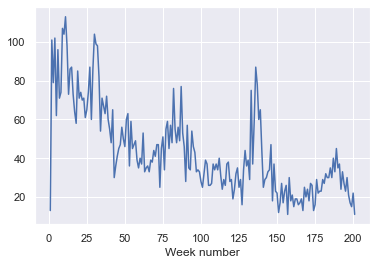

In [91]:
## visualization 
sns.lineplot(x=ByProduct.index, y=ByProduct.values)


Some observations from the plot include:

- There may be an decrease trend of sales over time.
- There appears to be systematic seasonality to the sales for each year.
- The seasonal signal appears to be declining over time, suggesting a multiplicative relationship (decreasing change).
- There do not appear to be any obvious outliers.
- The seasonality suggests that the series is almost certainly non-stationary.

#### ARIMA

The seasonality in the series is seemingly year-to-year. Seasonal data can be differenced by subtracting the observation from the same time in the previous cycle, in this case the same week in the previous year. This does mean that we will lose the first year of observations as there is no prior year to difference with.

In [92]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

ADF Statistic: -4.570606
p-value: 0.000146
Critical Values:
	1%: -3.476
	5%: -2.881
	10%: -2.577


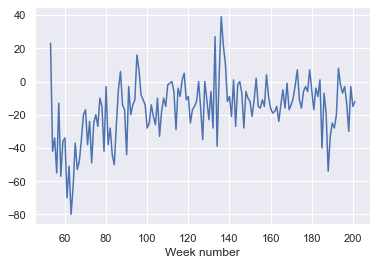

In [93]:
Weeks_in_year = 52 
stationary = difference(X, Weeks_in_year)
stationary.index = ByProduct.index[Weeks_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
stationary = stationary.astype('float')
stationary.to_csv('stationary.csv', header=False)
# plot
stationary.plot()
plt.show()

The results show that the test statistic value -4.570606 is smaller than the critical value at 1% of -3.476. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

In [94]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

##### ACF and PACF plots

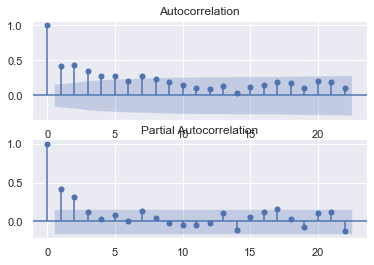

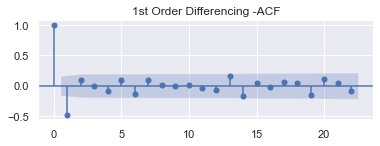

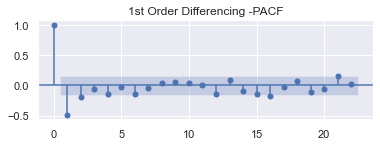

In [95]:
series = pd.read_csv('stationary.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
plt.figure()
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.figure()
plt.subplot(211)
plot_acf(series.diff().dropna(), ax=plt.gca(),title="1st Order Differencing -ACF")
plt.figure()
plt.subplot(211)
plot_pacf(series.diff().dropna(), ax=plt.gca(),title="1st Order Differencing -PACF")
plt.show()

##### Grid

In [97]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        Weeks_in_year = 52
        diff = difference(history, Weeks_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, Weeks_in_year)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


# evaluate combinations of p, d and q values for an ARIMA model

best_score = float("inf")
best_cfg = None

# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
#evaluate_models(series.values, p_values, d_values, q_values)


best_p = 0
best_d = 0
best_q = 0
best_score = float("inf")
best_cfg = None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                rmse = evaluate_arima_model(series.values, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                    best_p = p 
                    best_d = d
                    best_q = q
                print('ARIMA%s RMSE=%.3f' % (order,rmse))
            except:
                    continue
        
print ("Best parameters: p= ", best_p, ", d= ", best_d, ", q= ", best_q)

ARIMA(0, 0, 0) RMSE=30.628
ARIMA(0, 0, 1) RMSE=30.031
ARIMA(0, 0, 2) RMSE=29.319
ARIMA(0, 0, 3) RMSE=30.218
ARIMA(0, 1, 0) RMSE=36.468
ARIMA(0, 1, 1) RMSE=29.332
ARIMA(0, 1, 2) RMSE=29.878
ARIMA(0, 1, 3) RMSE=29.353
ARIMA(0, 2, 0) RMSE=64.297
ARIMA(0, 2, 1) RMSE=37.486
ARIMA(1, 0, 0) RMSE=29.647
ARIMA(1, 1, 0) RMSE=31.234
ARIMA(1, 1, 1) RMSE=29.193
ARIMA(1, 1, 2) RMSE=29.784
ARIMA(1, 2, 0) RMSE=46.076
ARIMA(2, 0, 0) RMSE=28.624
ARIMA(2, 0, 1) RMSE=28.661
ARIMA(2, 0, 2) RMSE=30.729
ARIMA(2, 1, 0) RMSE=30.607
ARIMA(2, 1, 1) RMSE=30.573
ARIMA(2, 2, 0) RMSE=39.695
ARIMA(2, 2, 1) RMSE=32.818
ARIMA(3, 0, 0) RMSE=29.067
ARIMA(3, 0, 1) RMSE=30.831
ARIMA(3, 1, 0) RMSE=31.389
ARIMA(3, 1, 1) RMSE=30.745
ARIMA(3, 2, 0) RMSE=39.229
Best parameters: p=  2 , d=  0 , q=  0


In [98]:
predictions = []
for i in range(len(test)):
    # difference data
    Weeks_in_year = 52
    diff = difference(history, Weeks_in_year)
    diff = diff.astype('float')
    # predict
    model = ARIMA(diff, order=(best_p, best_d, best_q))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, Weeks_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=22.268, Expected=15.000
>Predicted=9.667, Expected=19.000
>Predicted=10.986, Expected=19.000
>Predicted=24.394, Expected=16.000
>Predicted=8.469, Expected=17.000
>Predicted=13.514, Expected=19.000
>Predicted=19.126, Expected=13.000
>Predicted=-0.138, Expected=25.000
>Predicted=24.344, Expected=20.000
>Predicted=14.335, Expected=24.000
>Predicted=13.875, Expected=18.000
>Predicted=-4.107, Expected=27.000
>Predicted=3.318, Expected=26.000
>Predicted=15.489, Expected=13.000
>Predicted=11.072, Expected=16.000
>Predicted=7.764, Expected=29.000
>Predicted=13.984, Expected=22.000
>Predicted=17.009, Expected=23.000
>Predicted=15.198, Expected=23.000
>Predicted=16.055, Expected=29.000
>Predicted=18.716, Expected=27.000
>Predicted=20.811, Expected=32.000
>Predicted=22.350, Expected=30.000
>Predicted=24.053, Expected=30.000
>Predicted=23.676, Expected=35.000
>Predicted=25.978, Expected=30.000
>Predicted=26.506, Expected=40.000
>Predicted=28.665, Expected=33.000
>Predicted=30.488, Expec

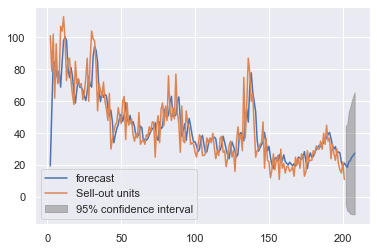

In [99]:
model = ARIMA(ByProduct, order=(best_p, best_d, best_q))
results = model.fit()
results.plot_predict(1, len(ByProduct)+6)

###### Results for the next 6 weeks

In [100]:
results.predict(1, len(ByProduct)+6)[-6:]

203    18.490514
204    21.972605
205    22.832853
206    24.791500
207    26.011436
208    27.423432
dtype: float64

In [101]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         Sell-out units   No. Observations:                  201
Model:                     ARMA(2, 0)   Log Likelihood                -796.681
Method:                       css-mle   S.D. of innovations             12.694
Date:                Wed, 02 Jun 2021   AIC                           1601.362
Time:                        14:00:31   BIC                           1614.575
Sample:                             0   HQIC                          1606.708
                                                                              
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   42.4223      7.092      5.981      0.000      28.522      56.323
ar.L1.Sell-out units     0.4215      0.069      6.075      0.000       0.286       0.558
ar.L2.Sell-out units     0.4584      0.071      6.492      0.000       0.320       0.597
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0872           +0.0000j            1.0872            0.0000
AR.2           -2.0068           +0.0000j            2.0068            0.5000
-----------------------------------------------------------------------------
"""

###### Evaluation

In [102]:
# # Mean Absolute Error (MAE)
MAE = np.mean(abs(predictions - test))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(predictions - test))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(predictions , test)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(predictions - test)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(test, predictions)/ test))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(test, predictions)/ test))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

Mean Absolute Error (MAE): 10.04
Median Absolute Error (MedAE): 8.22
Mean Squared Error (MSE): 164.74
Root Mean Squared Error (RMSE): 12.84
Mean Absolute Percentage Error (MAPE): 41.67 %
Median Absolute Percentage Error (MDAPE): 35.55 %


### Units Product forecast by Point-of-Sale (6 weeks ahead)

In [6]:
#example
product = 21
PointOfSale = 1

In [7]:
df_ProdPoint = df_weekly.groupby(by=[df_weekly['Date'],'ProductName_ID', 'Point-of-Sale_ID'])[['Sell-out units']].sum()

In [8]:
df_ProdPoint.reset_index(inplace=True)

In [9]:
df_ProdPoint = df_ProdPoint[(df_ProdPoint['ProductName_ID']==product) & (df_ProdPoint['Point-of-Sale_ID']==PointOfSale)]
if(len(df_ProdPoint)<55):
    print ('it is not possible to make the forecast for the chosen Product and Point of Sale due to the small number of observations')

In [10]:
df_ProdPoint.reset_index(inplace=True)
df_ProdPoint.index += 1
df_ProdPoint.index.names = ['Week number']
df_ProdPoint.drop(columns='index', inplace=True)
df_ProdPoint.head()

,Date,ProductName_ID,Point-of-Sale_ID,Sell-out units
Week number,,,,
1,2015-12-28/2016-01-03,21,1,2
2,2016-01-04/2016-01-10,21,1,51
3,2016-01-11/2016-01-17,21,1,64
4,2016-01-18/2016-01-24,21,1,31
5,2016-01-25/2016-01-31,21,1,33


In [11]:
df_ProdPoint = df_ProdPoint['Sell-out units']

Firstly, we can split the dataset into train and test sets directly. We’re careful to always convert a loaded dataset to float32 in case the loaded data still has some String or Integer data types.

In [12]:
#prepare data

X = df_ProdPoint.copy()
X = X.values
X = X.astype('float32')
train_size = int(len(X) * 0.80)
train, test = X[0:train_size], X[train_size:]

We will evaluate the performance of predictions using the root mean squared error (RMSE) among other metrics. For example, the RMSE will give more weight to predictions that are grossly wrong and will have the same units as the original data.

Candidate models will be evaluated using walk-forward validation.

This is because a rolling-forecast type model is required from the problem definition. This is where one-step forecasts are needed given all available data.

The walk-forward validation will work as follows:

- The first 80% of the dataset will be held back to train the model.
- The remaining 20% of the dataset will be iterated and test the model.
- For each step in the test dataset:
 - A model will be trained.
 - A one-step prediction made and the prediction stored for later evaluation.
 - The actual observation from the test dataset will be added to the training dataset for the next iteration.
 - The predictions made during the iteration of the test dataset will be evaluated and some metrics score reported.

In [13]:
# walk-forward validation
history = [x for x in train]
predictions = []
for i in range(len(test)):
    # predict
    yhat = history[-1] # prediction made by the model -> yhat
    predictions.append(yhat)
    # observation
    obs = i
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs)) # The prediction and observation are printed of each observation on the test dataset for a sanity check prediction in case there are issues with the model
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=12.000, Expected=  0
>Predicted=0.000, Expected=  1
>Predicted=1.000, Expected=  2
>Predicted=2.000, Expected=  3
>Predicted=3.000, Expected=  4
>Predicted=4.000, Expected=  5
>Predicted=5.000, Expected=  6
>Predicted=6.000, Expected=  7
>Predicted=7.000, Expected=  8
>Predicted=8.000, Expected=  9
>Predicted=9.000, Expected= 10
>Predicted=10.000, Expected= 11
>Predicted=11.000, Expected= 12
>Predicted=12.000, Expected= 13
>Predicted=13.000, Expected= 14
>Predicted=14.000, Expected= 15
>Predicted=15.000, Expected= 16
>Predicted=16.000, Expected= 17
>Predicted=17.000, Expected= 18
>Predicted=18.000, Expected= 19
>Predicted=19.000, Expected= 20
>Predicted=20.000, Expected= 21
>Predicted=21.000, Expected= 22
>Predicted=22.000, Expected= 23
>Predicted=23.000, Expected= 24
>Predicted=24.000, Expected= 25
>Predicted=25.000, Expected= 26
>Predicted=26.000, Expected= 27
>Predicted=27.000, Expected= 28
>Predicted=28.000, Expected= 29
>Predicted=29.000, Expected= 30
>Predicted=30.000,

we can see that the persistence model achieved an RMSE of 15.252. This means that on average, the model was wrong by about thirty-four sales for each prediction made.

<AxesSubplot:xlabel='Week number'>

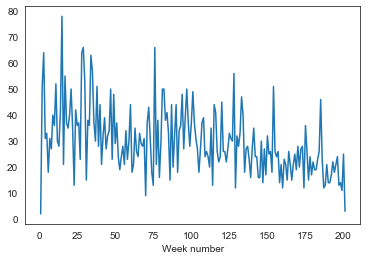

In [14]:
## visualization 
sns.lineplot(x=df_ProdPoint.index, y=df_ProdPoint.values)


Some observations from the plot include:

- There may be an decrease trend of sales over time.
- There appears to be systematic seasonality to the sales for each year.
- The seasonal signal appears to be declining over time, suggesting a multiplicative relationship (decreasing change).
- There do not appear to be any obvious outliers.
- The seasonality suggests that the series is almost certainly non-stationary.

#### ARIMA

The seasonality in the series is seemingly year-to-year. Seasonal data can be differenced by subtracting the observation from the same time in the previous cycle, in this case the same week in the previous year. This does mean that we will lose the first year of observations as there is no prior year to difference with.

In [15]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

ADF Statistic: -11.745985
p-value: 0.000000
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577


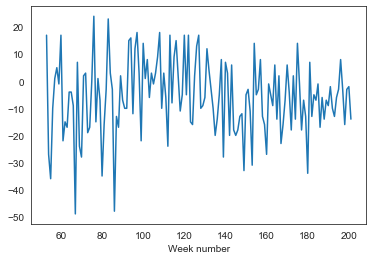

In [16]:
Weeks_in_year = 52 
stationary = difference(X, Weeks_in_year)
stationary.index = df_ProdPoint.index[Weeks_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary1.csv', header=False)
stationary = stationary.astype('float')
# plot
stationary.plot()
plt.show()

The results show that the test statistic value -11.745985 is smaller than the critical value at 1% of -3.475. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

In [17]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

##### ACF and PACF plots

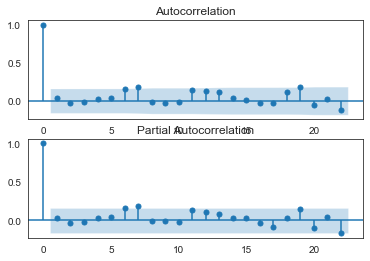

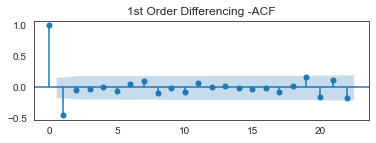

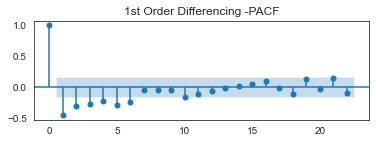

In [18]:
series = pd.read_csv('stationary1.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
plt.figure()
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.figure()
plt.subplot(211)
plot_acf(series.diff().dropna(), ax=plt.gca(),title="1st Order Differencing -ACF")
plt.figure()
plt.subplot(211)
plot_pacf(series.diff().dropna(), ax=plt.gca(),title="1st Order Differencing -PACF")
plt.show()

##### Grid

In [21]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        Weeks_in_year = 52
        diff = difference(history, Weeks_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, Weeks_in_year)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


# evaluate combinations of p, d and q values for an ARIMA model

best_score = float("inf")
best_cfg = None

# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
#evaluate_models(series.values, p_values, d_values, q_values)


best_p = 0
best_d = 0
best_q = 0
best_score = float("inf")
best_cfg = None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                rmse = evaluate_arima_model(series.values, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                    best_p = p 
                    best_d = d
                    best_q = q
                print('ARIMA%s RMSE=%.3f' % (order,rmse))
            except:
                    continue
        
print ("Best parameters: p= ", best_p, ", d= ", best_d, ", q= ", best_q)

ARIMA(0, 0, 0) RMSE=22.792
ARIMA(0, 0, 1) RMSE=22.839
ARIMA(0, 0, 2) RMSE=24.010
ARIMA(0, 0, 3) RMSE=24.488
ARIMA(0, 1, 0) RMSE=29.604
ARIMA(0, 1, 1) RMSE=22.823
ARIMA(0, 1, 2) RMSE=22.949
ARIMA(0, 1, 3) RMSE=23.464
ARIMA(0, 2, 0) RMSE=50.336
ARIMA(0, 2, 1) RMSE=30.357
ARIMA(0, 2, 2) RMSE=23.268
ARIMA(0, 2, 3) RMSE=27.340
ARIMA(1, 0, 0) RMSE=22.789
ARIMA(1, 0, 1) RMSE=23.036
ARIMA(1, 0, 2) RMSE=24.260
ARIMA(1, 0, 3) RMSE=24.636
ARIMA(1, 1, 0) RMSE=26.755
ARIMA(1, 2, 0) RMSE=39.246
ARIMA(2, 0, 0) RMSE=23.210
ARIMA(2, 0, 1) RMSE=24.212
ARIMA(2, 0, 2) RMSE=24.995
ARIMA(2, 1, 0) RMSE=25.781
ARIMA(2, 2, 0) RMSE=35.031
ARIMA(3, 0, 0) RMSE=23.532
ARIMA(3, 0, 1) RMSE=23.801
ARIMA(3, 0, 3) RMSE=25.917
ARIMA(3, 1, 0) RMSE=25.361
ARIMA(3, 2, 0) RMSE=33.691
Best parameters: p=  1 , d=  0 , q=  0


In [22]:
predictions = []
for i in range(len(test)):
    # difference data
    Weeks_in_year = 52
    diff = difference(history, Weeks_in_year)
    # predict
    model = ARIMA(diff, order=(best_p, best_d, best_q))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, Weeks_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=18.176, Expected=23.000
>Predicted=26.019, Expected=21.000
>Predicted=25.922, Expected=15.000
>Predicted=24.352, Expected=26.000
>Predicted=28.941, Expected=21.000
>Predicted=27.751, Expected=15.000
>Predicted=26.143, Expected=21.000
>Predicted=28.900, Expected=25.000
>Predicted=30.960, Expected=19.000
>Predicted=29.330, Expected=28.000
>Predicted=33.240, Expected=20.000
>Predicted=12.858, Expected=27.000
>Predicted=19.702, Expected=28.000
>Predicted=14.847, Expected=12.000
>Predicted=22.191, Expected=36.000
>Predicted=21.989, Expected=26.000
>Predicted=14.201, Expected=15.000
>Predicted=18.380, Expected=24.000
>Predicted=23.506, Expected=17.000
>Predicted=13.456, Expected=22.000
>Predicted=26.504, Expected=19.000
>Predicted=14.104, Expected=19.000
>Predicted=24.030, Expected=23.000
>Predicted=23.937, Expected=26.000
>Predicted=8.672, Expected=46.000
>Predicted=45.958, Expected=23.000
>Predicted=18.895, Expected=12.000
>Predicted=7.505, Expected=13.000
>Predicted=20.700, Exp

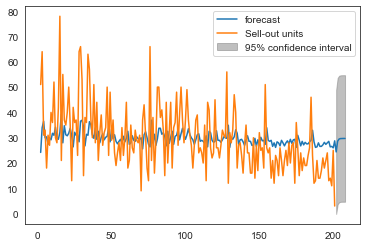

In [24]:
model = ARIMA(df_ProdPoint, order=(best_p, best_d, best_q))
results = model.fit()
results.plot_predict(1, len(df_ProdPoint)+6)

###### Results for the next 6 weeks

In [25]:
results.predict(1, len(df_ProdPoint)+6)[-6:]

203    28.640148
204    29.488050
205    29.656896
206    29.690520
207    29.697215
208    29.698548
dtype: float64

In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         Sell-out units   No. Observations:                  201
Model:                     ARMA(1, 0)   Log Likelihood                -792.928
Method:                       css-mle   S.D. of innovations             12.502
Date:                Wed, 02 Jun 2021   AIC                           1591.855
Time:                        14:20:12   BIC                           1601.765
Sample:                             0   HQIC                          1595.865
                                                                              
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   29.6989      1.100     26.996      0.000      27.543      31.855
ar.L1.Sell-out units     0.1991      0.071      2.820      0.005       0.061       0.338
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            5.0217           +0.0000j            5.0217            0.0000
-----------------------------------------------------------------------------
"""

##### Evaluation

In [27]:
# # Mean Absolute Error (MAE)
MAE = np.mean(abs(predictions - test))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(predictions - test))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(predictions , test)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(predictions - test)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(test, predictions)/ test))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(test, predictions)/ test))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

Mean Absolute Error (MAE): 8.56
Median Absolute Error (MedAE): 6.96
Mean Squared Error (MSE): 123.41
Root Mean Squared Error (RMSE): 11.11
Mean Absolute Percentage Error (MAPE): 56.2 %
Median Absolute Percentage Error (MDAPE): 35.09 %
